# Le challenge

**Objectif**

L'objectif de ce challenge est de prédire la consommation électrique de l’île d'Ouessant à 8 jours, en s’aidant des données suivantes : 
* un an de données de consommation historiques, à la maille horaire (conso_train.csv), 
* un an de données météorologiques à la maille tri-horaire, issues de la proche station météorologique de Brest (meteo_train.csv), 
* une semaine de données météorologiques à la maille tri-horaire, issues de la même station et faisant office de prédiction météorologique (meteo_prev.csv).

Au délà de cet aspect prévision, ce challenge s'inscrit également dans le cadre d'un projet rouge qui est réalisé en équipe.



---



**Methodologies**

Il s'agit bien évidement d'un ***problème de régression*** à partir de données qui sont des ***séries temporelles***. Une des solutions classique de prévisions à partir de serie temporelles reste les modèles ***ARMA*** et ***ARIMA***. Etant donnée que notre objectif est d'explorer les méthodologies de machine learning, je me contenterais des outils disponible dans ce champ d'application. Une des techniques (après quelques recherches) qui ressort le plus souvent pour le traitement de ce problème est le ***reseau de neuronne recurants (LSTM)***. Je partirais donc du postulat que ce modèle pourrait donner de bon résultats et plus tard explorer les deux autres modèles que je juges utiles (***SVM*** et ***arbre de decision***).

Pour évaluer les modèles je me contenterais d'utiliser les critères d'évaluation utilisé dans le cadre du challenge, savoir, l'erreur absolue moyenne en pourcentage (***MAPE***), puis  l'erreur quadratique moyenne (***RMSE***)

La première hypothèse faite sera de considérer que les prévisions météorologiques comme parfaites.



---



# Les données

Les données sont fournies par les organisateurs du challenge. Elles ont été téléchargé à partir d'un lien qui avait été mis à disposition pour une durée limitée. Les données sont constituées comme suit:


*   conso_train : qui contient toutes les données de consomation (puissance en Kw). C'est notre variable à prédire,
*   meteo_train : qui contient toutes les données météorologiques. Ceux sont nos prédicteurs,
*   meteo_prev  : qui contient toutes les données météorologiques pour lesquelles il faudra fournir des prévisions,
*   sample_solution : qui contient un example de comment notre solution prévisionnelle final devra être soumise.




---



# Les packages

**installation**

In [180]:
!pip install --upgrade windrose

Requirement already up-to-date: windrose in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (from windrose)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (from windrose)
Requirement already up-to-date: python-dateutil>=2.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)
Requirement already up-to-date: pytz in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)
Requirement already up-to-date: six>=1.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)
Requirement already up-to-date: cycler>=0.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)
Requirement already up-to-date: kiwisolver>=1.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)




---



**Importation**

In [ ]:
import pytz  # Pour retablir les dates au bon time zone
import numpy as np  # Pour la manipulation des tableaux ndarray
import pandas as pd  # Pour la manipulationd des données DataFrame
import seaborn as sns  # Pour la visualisation des données
import matplotlib.pyplot as plt  # Pour la visualisation
import matplotlib.cm as cm  # Pour les couleurs

from pandas import concat  # Pour la concatenation de DataFrame
from sklearn.model_selection import GridSearchCV
from windrose import WindroseAxes  # Pour la visualisation des données méteo

from statsmodels import api as sm  # Pour l'étude des series temporelles
from statsmodels.graphics import tsaplots  # Pour l'étude de l'autocorrélation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Pour l'étude de l'autocorrélation
from statsmodels.tsa.stattools import adfuller  # Pour le test de Dickey - Fuller de marche aléatoire

from sklearn.pipeline import Pipeline, FeatureUnion # Pour des pipeline lors du preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, Imputer  # Pour faire de la normalisation
from sklearn.metrics import mean_absolute_error  # Pour évaluer les modèles
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin

from keras.optimizers import SGD # Optimizer pour nos modèles
from keras.models import Sequential # Pour faire un modèle sequentiel
from keras.layers import Dense, LSTM # Pour faire un réseau de neuronne recursif
from keras.callbacks import EarlyStopping, ModelCheckpoint # Pour améliorer notre modèle et l'arreter prématurerment

import xgboost as xgb



---



**Paramètres pour jupyter**

In [ ]:
%matplotlib inline
sns.set()



---



**Class et fonctions**

In [ ]:

class DataFrameSelector(BaseEstimator, TransformerMixin):
	
	def __init__(self, attribute_names):
		self.attribute_names = attribute_names
	
	def fit(self, X, y = None):
		return self
	
	def transform(self, X, attribute_names = None):
		if attribute_names:
			return X[attribute_names]
		else:
			return X[self.attribute_names]


def explore_meteo_feature(feature = None):
	# Visualisation des données brute
	ax = meteo_train[feature].plot(figsize = (15, 10))
	
	ax.axvspan("2016-02-21", "2016-02-29", color = "red", alpha = 0.2)
	
	ax.set_xlabel("Date")
	ax.set_ylabel("Temperature")
	ax.set_title(f"Evolution de la {feature}")
	
	rolling = meteo_train[feature].rolling(window = "7D").agg("mean")
	rolling.plot(figsize = (15, 10), color = "red")
	
	plt.show()
	
	# Test de Dickey-Fulller
	result = adfuller(meteo_train[feature].dropna())
	print(f"La p-value pour le test de Dickey Fuller pour {feature} est : ", result[1])
	
	# Visualisation de la repartition
	fig = plt.figure(figsize = (15, 10))
	ax = sns.distplot(meteo_train[feature].dropna())
	plt.show()
	
	# Visualisation de la repartition par mois
	fig = plt.figure(figsize = (15, 10))
	ax = sns.violinplot(x = "month", y = feature, col = "day", data = meteo_train)
	plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
	plt.show()
	
	# Visualisation des composantes tendance, saisonalité, et bruit
	decomposition = sm.tsa.seasonal_decompose(meteo_train[[feature]].dropna(), freq = 240)
	
	trend = decomposition.trend
	seasonal = decomposition.seasonal
	noise = decomposition.resid
	
	decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
	decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
	decomposed.columns = ["tendance", "seasonalité", "bruit"]
	
	ax = decomposed["2015"].plot(subplots = True, figsize = (15, 10), fontsize = 15)
	plt.xlabel('Date', fontsize = 15)
	plt.legend(fontsize = 15)
	plt.show()
	
	# Visualisation de l'autocorrélation et de l'autocorrélation partielle
	fig, axes = plt.subplots(2, 1)
	fig = tsaplots.plot_acf(meteo_train[feature].dropna(), lags = 24, ax = axes[0])
	fig = tsaplots.plot_pacf(meteo_train[feature].dropna(), lags = 24, ax = axes[1])
	plt.show()


def series_to_supervised(data, index, n_in = 1, n_out = 1, dropnan = True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data, index = index)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis = 1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace = True)
	return agg



---



# Chargement des données

In [ ]:
url = "https://raw.githubusercontent.com/TheKonanKouassi/Projet-Fil-Rouge/master/Data/"

meteo_train = pd.read_csv(url + "meteo_train.csv", sep = ";")
conso_train = pd.read_csv(url + "conso_train.csv", sep = ";")
meteo_previ = pd.read_csv(url + "meteo_prev.csv", sep = ";")



---



# Exploration des données

In [185]:
print("="*35, "Info", "="*35)
print(meteo_train.info())

print("="*32, "Stats Desc", "="*32)
print(meteo_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 12 columns):
Date UTC           2928 non-null object
T¬∞ (C)            2864 non-null float64
P (hPa)            2864 non-null float64
HR (%)             2864 non-null float64
P.ros√©e (¬∞C)     2864 non-null float64
Visi (km)          2864 non-null float64
Vt. moy. (km/h)    2864 non-null float64
Vt. raf. (km/h)    2861 non-null float64
Vt. dir (¬∞)       2864 non-null float64
RR 3h (mm)         2592 non-null float64
Neige (cm)         971 non-null float64
Nebul. (octats)    2519 non-null float64
dtypes: float64(11), object(1)
memory usage: 274.6+ KB
None
================================ Stats Desc ================================
           T¬∞ (C)      P (hPa)       HR (%)  P.ros√©e (¬∞C)    Visi (km)  \
count  2864.000000  2864.000000  2864.000000     2864.000000  2864.000000   
mean     12.365154  1016.839525    

**Remarques** : 
* On peut remarquer qu'on a ***12 variables*** et ***2928 points*** de données.
* Les noms des variables ne sont pas très explicites, mais on peut en identifier certaines.
* La variable ***Date UTC n'a aucune valeurs manquantes***, mais les autres en ont exactement le même nombre à l'exception de quelques unes.
* La variable ***Date UTC a pour type object***, il faudra donc y remedier.
* Ces données méteorologiques étant à la maille tri-horaire, on peut supposer qu'il y a donc 8 observations par jour. Ce qui peut se confirmer en divisant 2928 par 8, ce qui donne exactement 366 et confirme que les données correspondent à une année entière.
* on a ***2928 - 2864 = 64 données manquantes***, soit*** 64 / 8 qui correspond à 8 jours*** de données que j'essayerai d'identifier
* Il faudra determiner à quoi correspond les variables suivantes : ***HR (%), P.ros√©e (¬∞C), RR 3h (mm), Neige (cm), Nebul. (octats),***.
* La variable ***Neige (cm)*** qui est sensé être en centimètre est presque tout le temps égale à 0 si elle n'est pas manquante. Il faudra se renseigner pour savoir si celà est normal et si c'est le cas, la supprimer. Je pense qu'il s'agit d'une variable binaire, mais celà reste à confirmer.
* La pluie sur 3h à 75% de ces données égalent à 0.


---


**Le descriptif des variables est le suivant** :
* T : Température (°C)
* P : Pression (hPa Hecto Pascal) mesuré en Hecto Pascal [meteo France](http://www.meteofrance.fr/publications/glossaire/153309-pression-atmospherique)
* HR : Humidité relative (%) mesure la quantité de vapeur d'eau présente dans l'air [wiki](https://fr.wikipedia.org/wiki/Humidité_relative) [meteo France](http://www.meteofrance.fr/publications/glossaire/152253-humidite-relative)
* Point de rosée (°C) [wiki](https://fr.wikipedia.org/wiki/Point_de_rosée) & [meteo France](http://www.meteofrance.fr/publications/glossaire/153221-point-de-rosee)
* Visi : Visibilité (km) [meteo France](http://www.meteofrance.fr/publications/glossaire/154673-visibilite)
* Vt moy : Vent moyen du vent (km/h) [meteo France](http://www.meteofrance.fr/publications/glossaire/154596-vent-moyen)
* Vt raf : rafales de vent (km/h) [meteo France](http://www.meteofrance.fr/publications/glossaire/153540-rafale)
* Vt dir : direction du vent (° degrés) [meteo France](http://www.meteofrance.fr/publications/glossaire/150367-direction-du-vent)
* RR 3 : pluie sur 3h (mm)
* Neige (cm)
* Nebul. : nébulosité ou couverture nuageuse (octats) [meteo France](http://www.meteofrance.fr/publications/glossaire/152825-nebulosite)

Ce descriptif a été obtenu au près de Mme. [Valérie Robert](https://www.math.u-psud.fr/~robert/index.html).




---



In [186]:
print("="*35, "Info", "="*35)
print(conso_train.info())

print("="*32, "Stats Desc", "="*32)
print(conso_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
date         8760 non-null object
puissance    8760 non-null float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB
None
================================ Stats Desc ================================
         puissance
count  8760.000000
mean    752.559174
std     272.383368
min     294.166667
25%     527.000000
50%     719.250000
75%     950.208333
max    1732.166667


**Remarques**:
* On peut remarquer qu'on a ***2 variables*** et ***8759 points*** de données.
* On peut aussi remarquer qu'il n'y a aucune données manquantes.
* La variable ***Date*** étant de type object devra être converit au non format.
* Ces données de consomation étant à la maille horaire, elle devrait donc correspondre à ***3 fois*** la taille des données météo. Cependant ***8760 / 2928 = 2.9918032787***, ce qui n'est pas exactement 3. Il faudra donc se pencher sur la question de la corrrespondance des données.
* La consommation (en Kw) varie entre ***294.16 Kw et 1732 Kw***, avec en ***moyenne 752 Kw***.

**---------------------------------**

Le code ci-dessous réalise les opérations suivantes:
* Renomme les colonnes de données météo.
* Retablit la time zone à celle de Paris afin d'avoir des dates et heures plus cohérentes avec la réalité.
* Convertit les données des dates au format Datetime.
* Definit les dates comme étant les index de nos DataFrame.


In [ ]:
columns = {"Date UTC"       : "date",
           "T¬∞ (C)"        : "temperature", 
           "P (hPa)"        : "pression",
           "HR (%)"         : "humidite_relative", 
           "P.ros√©e (¬∞C)" : "point_rose",
           "Visi (km)"      : "visibilite", 
           "Vt. moy. (km/h)": "vent_moyen", 
           "Vt. raf. (km/h)": "vent_rafale",
           "Vt. dir (¬∞)"   : "vent_direction", 
           "RR 3h (mm)"     : "pluie_3h",
           "Neige (cm)"     : "neige",
           "Nebul. (octats)": "nebulosite"}

meteo_train.rename(columns = columns, inplace = True)
meteo_previ.rename(columns = columns, inplace = True)

conso_train["date"] = pd.to_datetime(conso_train["date"])
meteo_train["date"] = pd.to_datetime(meteo_train["date"], format = "%d/%m/%y %Hh%M")
meteo_previ["date"] = pd.to_datetime(meteo_previ["date"], format = "%d/%m/%y %Hh%M")

conso_train.set_index("date", inplace = True)
meteo_train.set_index("date", inplace = True)
meteo_previ.set_index("date", inplace = True)

conso_train.index = conso_train.index.tz_localize(pytz.utc).tz_convert(pytz.timezone('Europe/Paris'))
meteo_train.index = meteo_train.index.tz_localize(pytz.timezone('Europe/Paris'))
meteo_previ.index = meteo_previ.index.tz_localize(pytz.timezone('Europe/Paris'))

conso_train = conso_train.reset_index().drop_duplicates(subset = "date").set_index("date")
meteo_previ = meteo_previ.reset_index().drop_duplicates(subset = "date").set_index("date")

## Exploration des données consommation

### Exploration de la structure des données

In [188]:
print("="*35, "Info", "="*35)
print(conso_train.info())

print("="*32, "Stats Desc", "="*32)
print(conso_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8759 entries, 2015-09-13 00:59:59+02:00 to 2016-09-13 00:00:00+02:00
Data columns (total 1 columns):
puissance    8759 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB
None
================================ Stats Desc ================================
         puissance
count  8759.000000
mean    752.520421
std     272.374766
min     294.166667
25%     527.000000
50%     719.166667
75%     950.083333
max    1732.166667


**Remarques**:
* Les données ont désormais pour index la date de prélèvement des données.
* Il n'y a aucune données manquantes.
* On remarque que les prélèvements débutent le ***2015-09-13 00:59:59+02:00*** et se termine le ***2016-09-13 00:00:00+02:00***. On peut donc remarquer que les prélèvements étaient fait en fin d'heure (hh:59:59) et à partir d'une certaine date les prélèvelement était fait en debut d"heure (hh:00:00).

---



In [189]:
# Début du 2015-12-31
print("="*13, "2015-12-31","="*13)
print(conso_train["2015-12-31"].head())
print()

# Fin du 2015-12-31
print("...")
print(conso_train["2015-12-31"].tail())
print()

# Début du 2016-01-01
print("="*13, "2016-01-01","="*13)
print(conso_train["2016-01-01"].head())
print()

# Fin du 2016-01-01
print("...")
print(conso_train["2016-01-01"].tail())

print("="*38)

============= 2015-12-31 =============
                             puissance
date                                  
2015-12-31 00:59:59+01:00  1158.666667
2015-12-31 01:59:59+01:00  1076.833333
2015-12-31 02:59:59+01:00  1059.500000
2015-12-31 03:59:59+01:00  1004.666667
2015-12-31 04:59:59+01:00   987.166667

...
                             puissance
date                                  
2015-12-31 18:59:59+01:00  1564.333333
2015-12-31 19:59:59+01:00  1518.166667
2015-12-31 20:59:59+01:00  1612.000000
2015-12-31 21:59:59+01:00  1732.166667
2015-12-31 22:59:59+01:00  1567.500000

============= 2016-01-01 =============
                             puissance
date                                  
2016-01-01 00:00:00+01:00  1453.200000
2016-01-01 01:00:00+01:00  1331.166667
2016-01-01 02:00:00+01:00  1213.500000
2016-01-01 03:00:00+01:00  1145.833333
2016-01-01 04:00:00+01:00  1078.333333

...
                             puissance
date                                  
2016-01-01 19:

**Remarques**:
* Les prélèvements débutait donc à hh:59:59 puis à partir du 1er Janvier 2016 les prélèvements se sont fait à hh:00:00.
* Et donc en 2015 les prélèvements s'éffectuaient de 00:59:59 (disons 1h) à 23:59:59 (disons 0h du jour suivant)
* En 2016 les prélèvements  s'éffectuaient de 00:00:00 à 23:00:00.
* Le 31 Decembre 2015, la donnée de 23:59:59 a été passé au 1er Janvier 2016 du fait de la nouvelle méthode de prélèvement, et donc le jour de 2015-12-31 compte seulement 23 données plutot que 24.
---



In [190]:
print(conso_train.tail())

                            puissance
date                                 
2016-09-12 20:00:00+02:00  533.166667
2016-09-12 21:00:00+02:00  504.000000
2016-09-12 22:00:00+02:00  608.333333
2016-09-12 23:00:00+02:00  509.833333
2016-09-13 00:00:00+02:00  435.000000


**Remarques**:
* Les prélèvements des consomations sont réalisés sont jusqu'au **2016-09-13 00:00:00+02:00**, alors que les données méteo se termine au **2016-02-28 21:00:00**, il faudrait donc supprimer cette dernière donnée qui se trouve également en début de meteo_prev.



---



In [191]:
print("="*13, "2015-10-24","="*13)
print(conso_train["2015-10-25"].head())
print()
print("="*13, "2016-03-27","="*13)
print(conso_train["2016-03-27"].head())

============= 2015-10-24 =============
                            puissance
date                                 
2015-10-25 00:59:59+02:00  792.500000
2015-10-25 01:59:59+02:00  697.000000
2015-10-25 02:59:59+01:00  609.166667
2015-10-25 03:59:59+01:00  589.000000
2015-10-25 04:59:59+01:00  598.333333

============= 2016-03-27 =============
                             puissance
date                                  
2016-03-27 00:00:00+01:00  1284.833333
2016-03-27 01:00:00+01:00  1139.666667
2016-03-27 03:00:00+02:00  1092.000000
2016-03-27 04:00:00+02:00  1065.666667
2016-03-27 05:00:00+02:00  1056.833333


**Remarques** :
* On peut remarquer le changement d'heure effectuer dans le nuit 25 Octobre 2015
* On peut remarquer le changement d'heure effectuer dans le nuit 27 Mars 2016



---



### Visualisation des données

In [ ]:
conso_train["hour"]  = conso_train.index.hour
conso_train["day"]   = conso_train.index.weekday
conso_train["month"] = conso_train.index.month

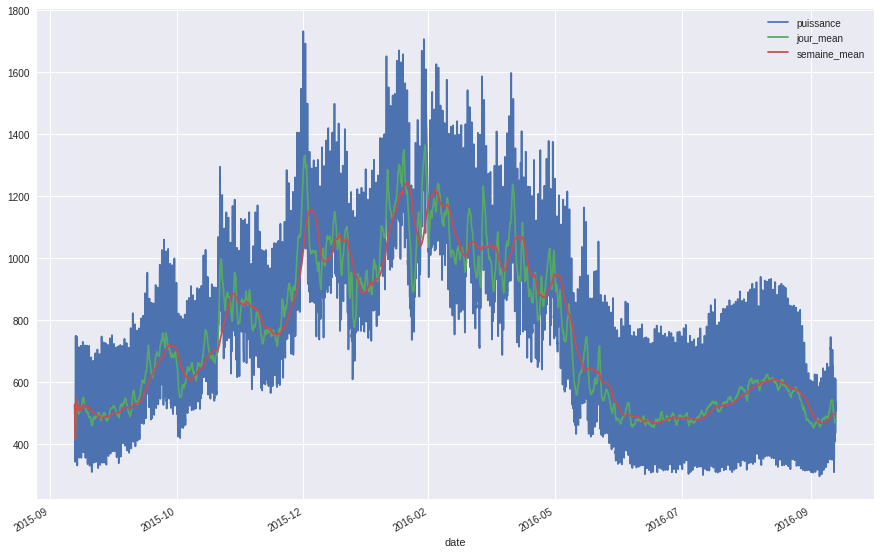

In [193]:
# Visualisation des données brutes
conso_train_day  = conso_train["puissance"].rolling(window = "24H").agg(["mean"]).add_prefix("jour_")
conso_train_week = conso_train["puissance"].rolling(window = "7D").agg(["mean"]).add_prefix("semaine_")

rolling = conso_train[["puissance"]].join(conso_train_day)
rolling = rolling.join(conso_train_week)

rolling.plot(figsize = (15, 10))
plt.show()

**Remarques**:
* On ne peut pas voir trop de details sur ce graphique, mais en gros on peut voir une augmentation de la consommaton puis une dimunition. Ce qui est normal au vu des saisons
* On peut quand même voir que la consommation baisse énormement en aout et remonte (surement les départ et les rétour de vacances)



---



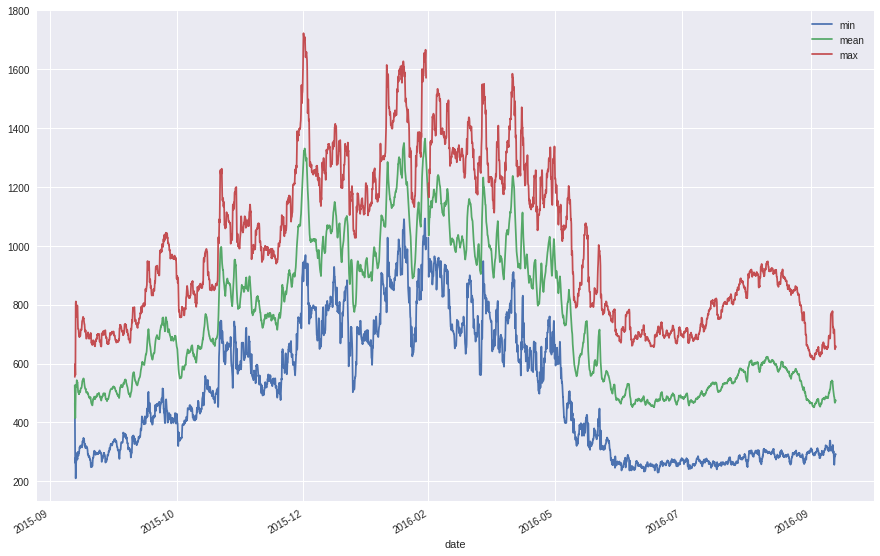

In [194]:
# Visualisation de la consommation moyenne et de l'interval de confiance
conso_train_stats = conso_train["puissance"].rolling(window = "24H").agg(["mean", "std"])

conso_train_stats["max"] = conso_train_stats["mean"] + 2 * conso_train_stats["std"]
conso_train_stats["min"] = conso_train_stats["mean"] - 2 * conso_train_stats["std"]

conso_train_stats[["min", "mean", "max"]].plot(figsize = (15, 10))
plt.show()



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


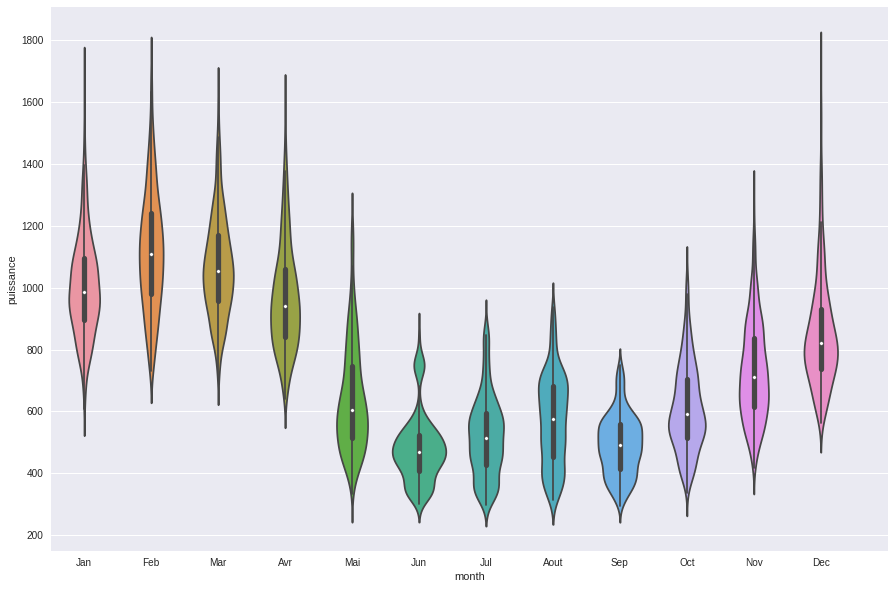

In [195]:
# Visualisation de la repartition par mois
fig = plt.figure(figsize = (15, 10))
sns.violinplot(x = "month", y = "puissance", col = "day", data = conso_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()

**Remarques**:
* On peut bien voir la dispersion au fil des mois



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


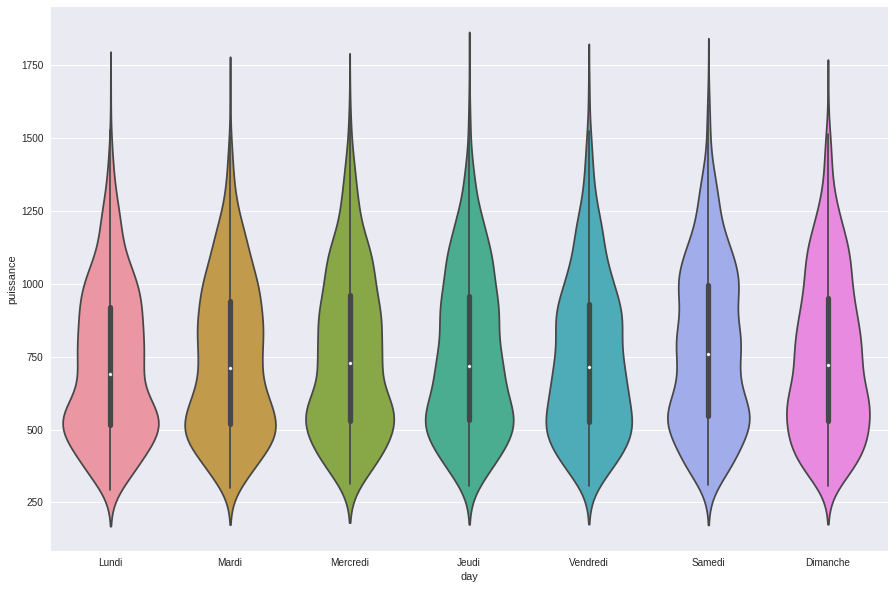

In [196]:
# Visualisation de la repartition par jour
fig = plt.figure(figsize = (15, 10))
sns.violinplot(x = "day", y = "puissance", col = "day", data = conso_train)
plt.xticks(np.arange(0, 7), ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"])
plt.show()

**Remarques**
* On peut remarquer une mediane un peu plus élévée pour le samedi, et donc une consommation un peu ples élévée.



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


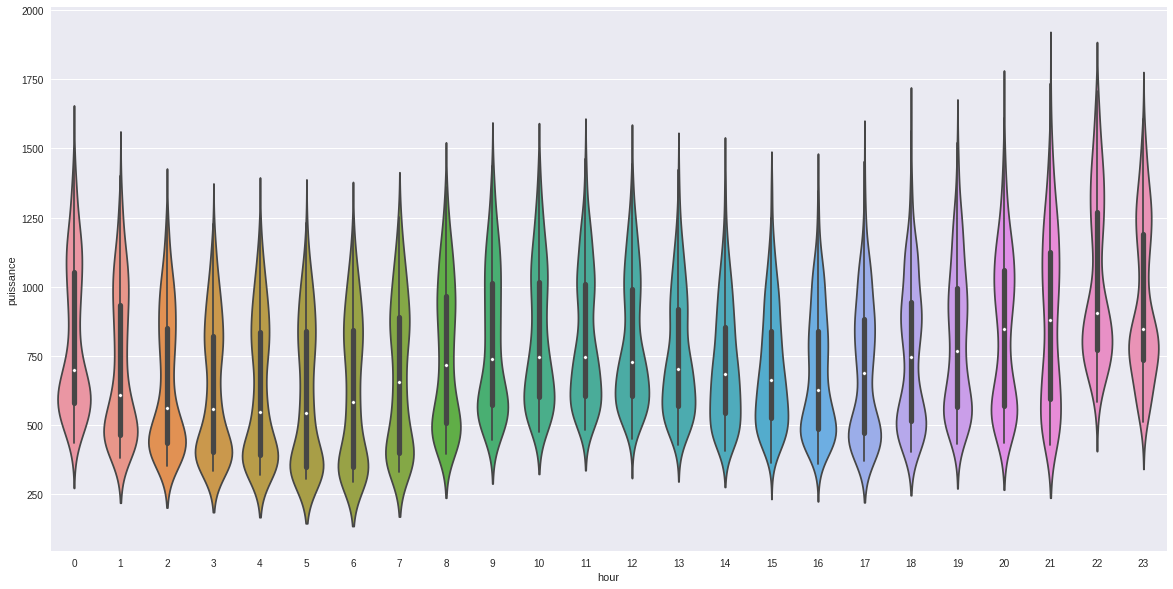

In [197]:
# Visualisation de la repartition par heures
fig = plt.figure(figsize = (20, 10))
sns.violinplot(x = "hour", y = "puissance", col = "day", data = conso_train)
plt.show()



---



/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


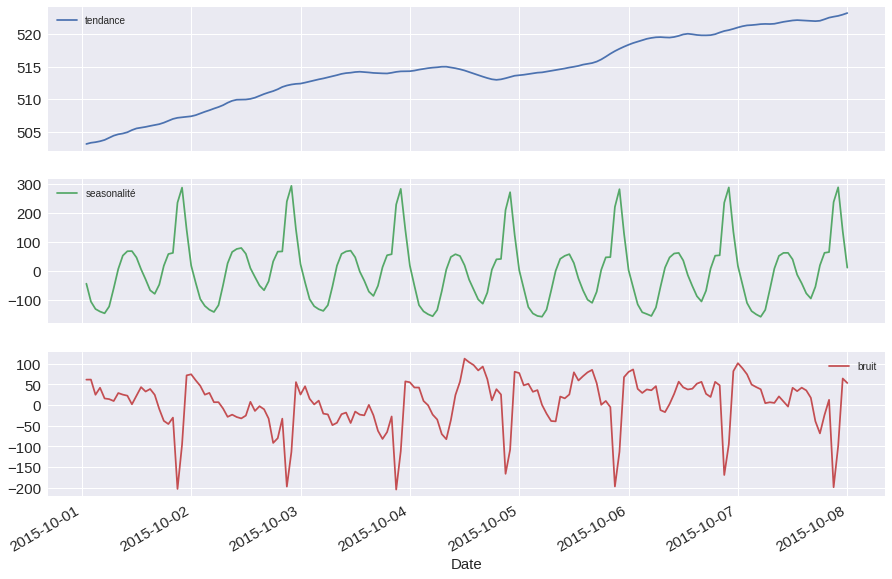

In [198]:
# Visualisation des composantes tendance, saisonalité, et bruit
decomposition = sm.tsa.seasonal_decompose(conso_train[["puissance"]].dropna(), freq = 240)

trend    = decomposition.trend
seasonal = decomposition.seasonal
noise    = decomposition.resid

decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
decomposed.columns = ["tendance", "seasonalité", "bruit"]

decomposed["2015-10-01": "2015-10-07"].plot(subplots = True, figsize = (15, 10), fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.show()

**Remarques**:
* On peut remarquer le pique à 12h et en fin de journée.
* On peut remarquer aussi une augmentation de l'amplitude en fin de semaine.
* Pour capter ce effet, on pourra extraire les jours et peut être les heures, pour en faire des données catégorielles



---



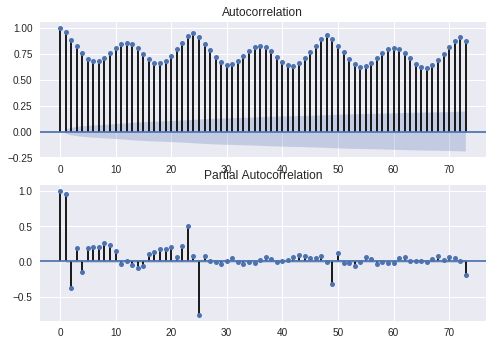

In [199]:
fig, ax = plt.subplots(2, 1)
plot_acf(conso_train["puissance"], lags = 73, ax = ax[0])
plot_pacf(conso_train["puissance"], lags = 73, ax = ax[1])
plt.show()

**Remarques**:
* On peut voir la dépendance entre les versions laggé sur 24h, mais surtout avec la 25h, soit la même heure, mais le jour précedent, et aussi la 49h, soit la même heure, mais deux jours avant, et ainsi de suite
* On pourra donc utiliser ces informations sur ces précendentes soit:
* donnée jj à t
* donnée jj à t-1
* donnée jj à t-2
* donnée jj-1 à t
* donnée jj-1 à t-1
* donnée jj-1 à t-2
* donnée jj-2 à t
* donnée jj-2 à t-1
* donnée jj-2 à t-2




---



In [200]:
# Test de Dickey-Fuller
result = adfuller(conso_train["puissance"])
result_diff = adfuller(conso_train["puissance"].diff().dropna())

print("La p-value pour le test de Dickey Fuller sur les données brutes est : ", result[1])
print("La p-value pour le test de Dickey Fuller sur les données différenciés : ", result_diff[1])

La p-value pour le test de Dickey Fuller sur les données brutes est :  0.1019640834879102
La p-value pour le test de Dickey Fuller sur les données différenciés :  3.362363763391206e-30


**Remarques**:
* On peut bien remarquer que les données brutes ne corrrespond pas à une marche àléatoire, ce qui est le cas pour la première difference



---



## Exploration des données météo

### Exploration de la structure des données

In [201]:
print("="*35, "Info", "="*35)
print(meteo_train.info())

print("="*32, "Stats Desc", "="*32)
print(meteo_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2015-09-13 00:00:00+02:00 to 2016-09-12 21:00:00+02:00
Data columns (total 11 columns):
temperature          2864 non-null float64
pression             2864 non-null float64
humidite_relative    2864 non-null float64
point_rose           2864 non-null float64
visibilite           2864 non-null float64
vent_moyen           2864 non-null float64
vent_rafale          2861 non-null float64
vent_direction       2864 non-null float64
pluie_3h             2592 non-null float64
neige                971 non-null float64
nebulosite           2519 non-null float64
dtypes: float64(11)
memory usage: 274.5 KB
None
================================ Stats Desc ================================
       temperature     pression  humidite_relative   point_rose   visibilite  \
count  2864.000000  2864.000000        2864.000000  2864.000000  2864.000000   
mean     12

**Remarques**:
* Le DataFrame a désormais pour index la date.
* Les données s'étendent du ***2015-09-13 00:00:00 au 2016-09-12 21:00:00***. Ce qui correspond bien à 8 données par jour.
* On peut remarquer que entre le  ***2015-09-13 et le 2016-09-12, il y a exactement 365 jours*** alors qu'on en trouvais 366 au paravant. Il faudra vérifier ce fait



---



In [202]:
mask = meteo_train["temperature"].isna()

print(meteo_train.loc[mask, :].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2016-02-21 00:00:00+01:00 to 2016-02-28 21:00:00+01:00
Data columns (total 11 columns):
temperature          0 non-null float64
pression             0 non-null float64
humidite_relative    0 non-null float64
point_rose           0 non-null float64
visibilite           0 non-null float64
vent_moyen           0 non-null float64
vent_rafale          0 non-null float64
vent_direction       0 non-null float64
pluie_3h             0 non-null float64
neige                0 non-null float64
nebulosite           0 non-null float64
dtypes: float64(11)
memory usage: 6.0 KB
None


**Remarques**:
* Les données manquantes pour la plus part des variables correspond à la tranche du ***2016-02-21 00:00:00 à 2016-02-28 21:00:00***
* Cette tranche devra donc être traitée (supprimée ou interpolée)

---



In [203]:
 meteo_train.index.value_counts().sort_values(ascending = False).head(10)

2016-06-26 03:00:00+02:00    2
2016-06-26 12:00:00+02:00    2
2016-06-26 00:00:00+02:00    2
2016-06-26 15:00:00+02:00    2
2016-06-26 18:00:00+02:00    2
2016-06-26 09:00:00+02:00    2
2016-06-26 06:00:00+02:00    2
2016-06-26 21:00:00+02:00    2
2015-10-02 15:00:00+02:00    1
2015-12-24 09:00:00+01:00    1
Name: date, dtype: int64

**Remarques**:
* Les données du **2016-06-26 sont dupliquées**
* Il faudra donc les supprimer.

---



In [204]:
conso_train = conso_train.reset_index().drop_duplicates(subset = "date").set_index("date")
meteo_train = meteo_train.reset_index().drop_duplicates(subset = "date").set_index("date")
meteo_previ = meteo_previ.reset_index().drop_duplicates(subset = "date").set_index("date")
meteo_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2015-09-13 00:00:00+02:00 to 2016-09-12 21:00:00+02:00
Data columns (total 11 columns):
temperature          2856 non-null float64
pression             2856 non-null float64
humidite_relative    2856 non-null float64
point_rose           2856 non-null float64
visibilite           2856 non-null float64
vent_moyen           2856 non-null float64
vent_rafale          2853 non-null float64
vent_direction       2856 non-null float64
pluie_3h             2584 non-null float64
neige                969 non-null float64
nebulosite           2511 non-null float64
dtypes: float64(11)
memory usage: 273.8 KB


**Remarques**:
* On a maintenant **2920** points de données.
* Quand on **divise 8760 par 2920** on obtient maintenant très exactement **3**. Ce qui correspond à ce dont on pourrait s'attendre.

---



### Visualisation des données

In [ ]:
meteo_train["hour"]  = meteo_train.index.hour
meteo_train["day"]   = meteo_train.index.weekday
meteo_train["month"] = meteo_train.index.month

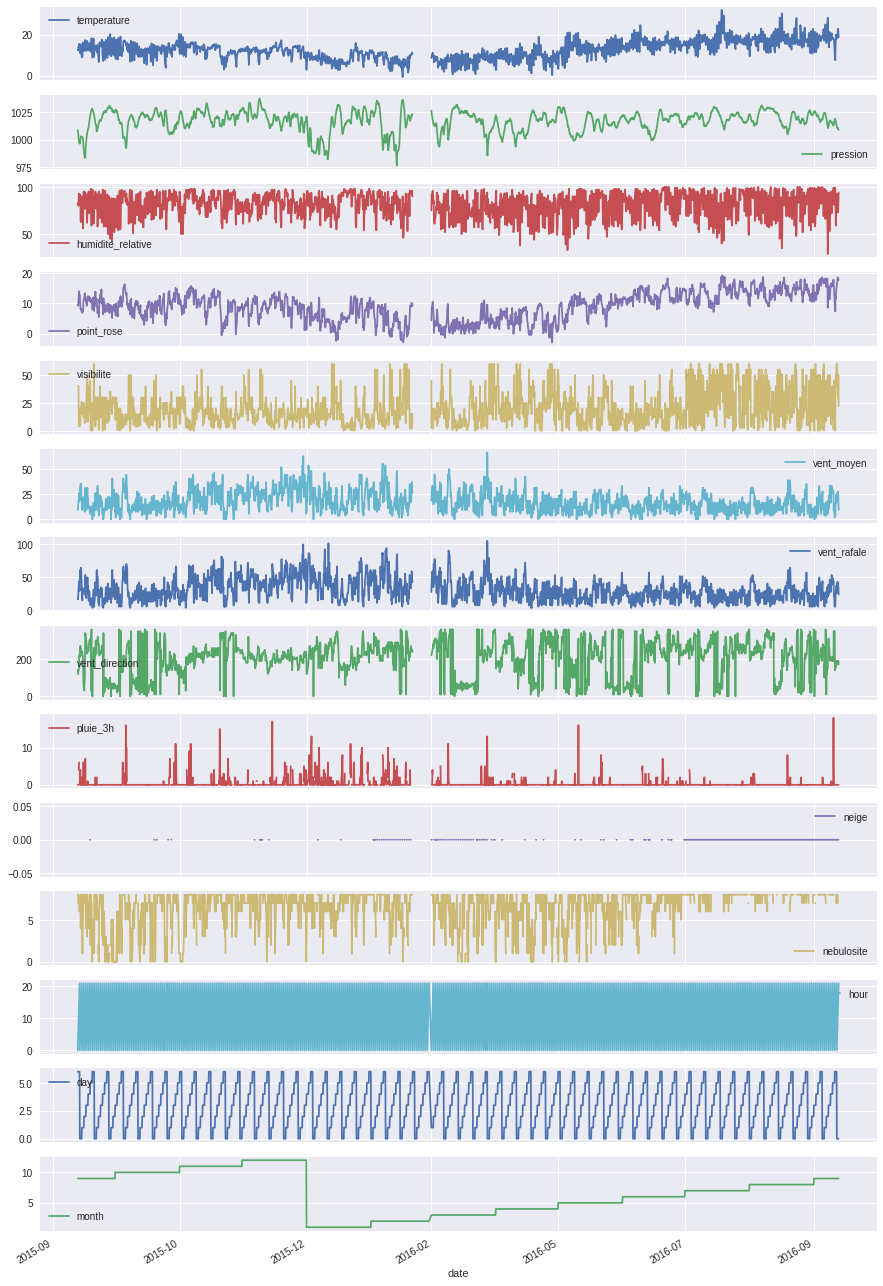

In [206]:
# Visualisation des données brutes
meteo_train.plot(subplots = True, figsize = (15, 25))
plt.show()

**Remarques**:
* On peut bien remarquer les données manquantes sur la tranche du ***2016-02-21 00:00:00 à 2016-02-28 21:00:00***



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


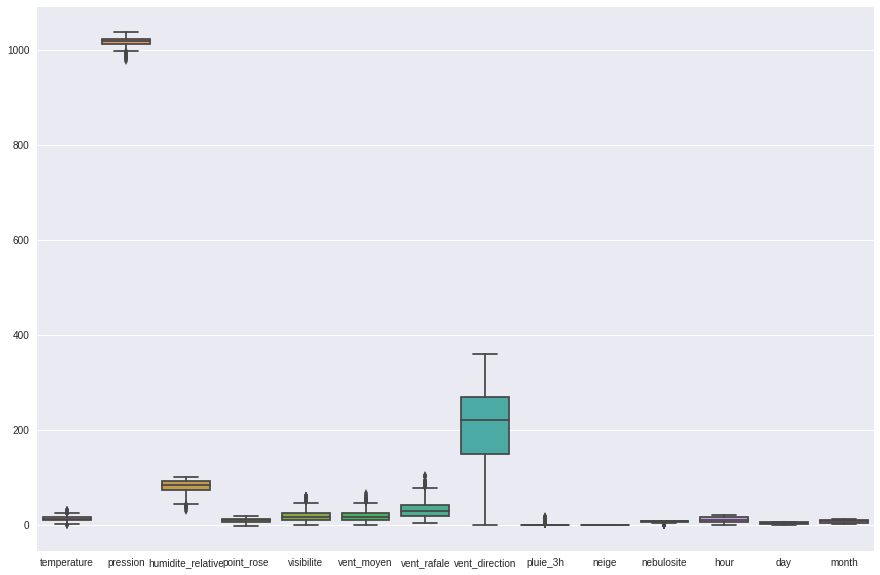

In [207]:
# Visualisation de la dispertion des données
fig = plt.figure(figsize = (15, 10))
ax = sns.boxplot(data = meteo_train)
plt.show()

**Remarques**:
* Les différentes variables ont des échelles très différentes, il faudra donc passer par une normalisation (ou pas).



---



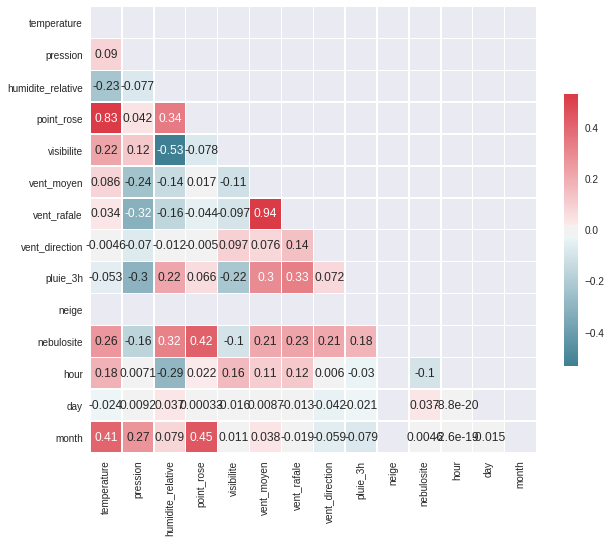

In [208]:
# Visualisation de la corrélation
corr = meteo_train.corr()

mask = np.zeros_like(corr, dtype = np.bool)

mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True)

plt.show()

**Remarques**:
* On peut remarquer de forte corrélation entre certaines variables, point de rosé et température, vent de rafale et vent moyen (évident).
* La variable neige n'est corrélé à aucune des autres, mais je pense qu'il doit avoir une forte corrélation avec la température, et donc son absence n'est pas trsè problèmatique



---



#### Temperature

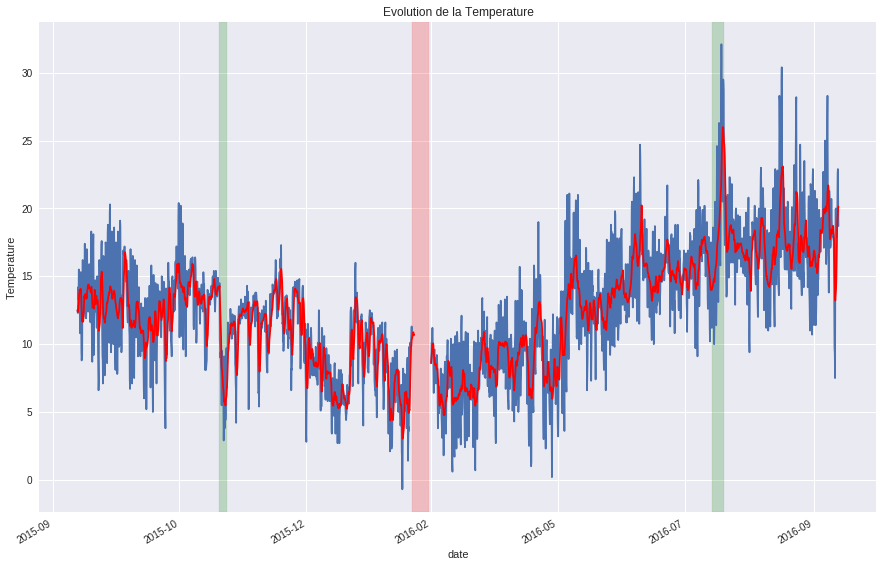

In [209]:
ax = meteo_train["temperature"].plot(figsize = (15,10))

ax.axvspan("2016-02-21", "2016-02-29", color = "red", alpha = 0.2)

ax.axvspan("2015-11-20", "2015-11-24", color = "green", alpha = 0.2)

ax.axvspan("2016-07-14", "2016-07-20", color = "green", alpha = 0.2)

ax.set_xlabel("Date")

ax.set_ylabel("Temperature")

ax.set_title("Evolution de la Temperature")

rolling = meteo_train["temperature"].rolling(window = "24H").agg("mean")

rolling.plot(figsize = (15,10), color = "red")

plt.show()

**Remarques**
* On peut remarquer en rouge les données manquantes en fin Février.
* On peut remarquer une tendance à la baisse avant mars 2016 et une tendance à hause après.
* On peut remarquer une grosse baisse de la température entre le **2015-11-20 et le 2015-11-24**
* On peut remarquer une grosse hausse de la température entre le **2016-07-14 et le 2016-07-20**



---



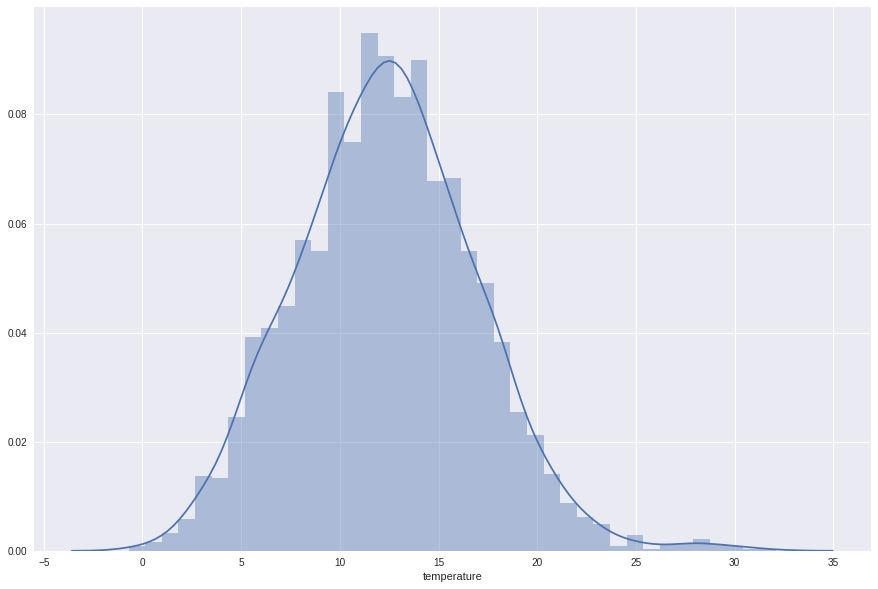

In [210]:
fig = plt.figure(figsize=(15,10))
ax = sns.distplot(meteo_train["temperature"].dropna())
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


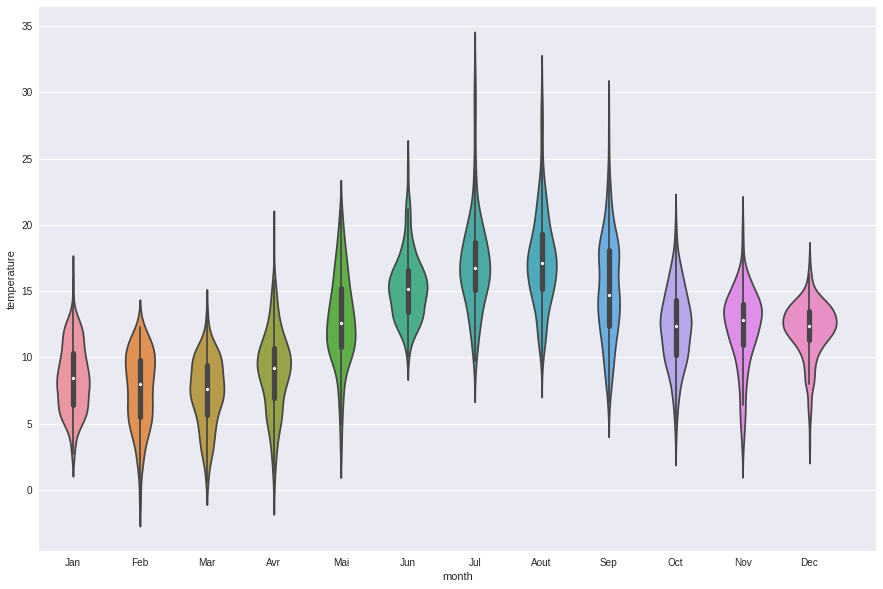

In [211]:
fig = plt.figure(figsize=(15,10))
ax = sns.violinplot(x = "month", y="temperature", col = "day", data=meteo_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()

**Remarques**:
* On peut remarquer une nette tendance à la hausse entre le mois de mars et celui d'août, puis une baisse.



---



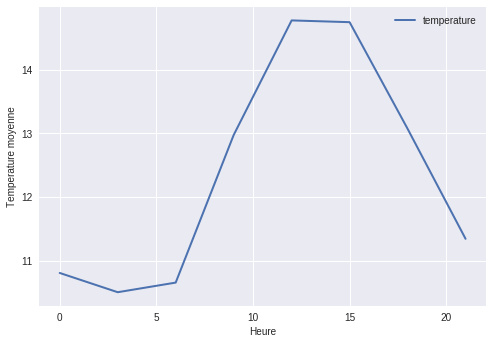

In [212]:
index_hour = meteo_train.index.hour

temperature_by_hour = meteo_train["temperature"].groupby(index_hour).mean()

ax = temperature_by_hour.plot(fontsize = 10, linewidth = 2)

ax.set_xlabel('Heure', fontsize = 10)
ax.set_ylabel('Temperature moyenne', fontsize = 10)
ax.legend(fontsize = 10)
plt.show()

**Remarque**:
* La température atteint son mininum entre 3h et 4h et son maximum entre 11h et 15h.



---



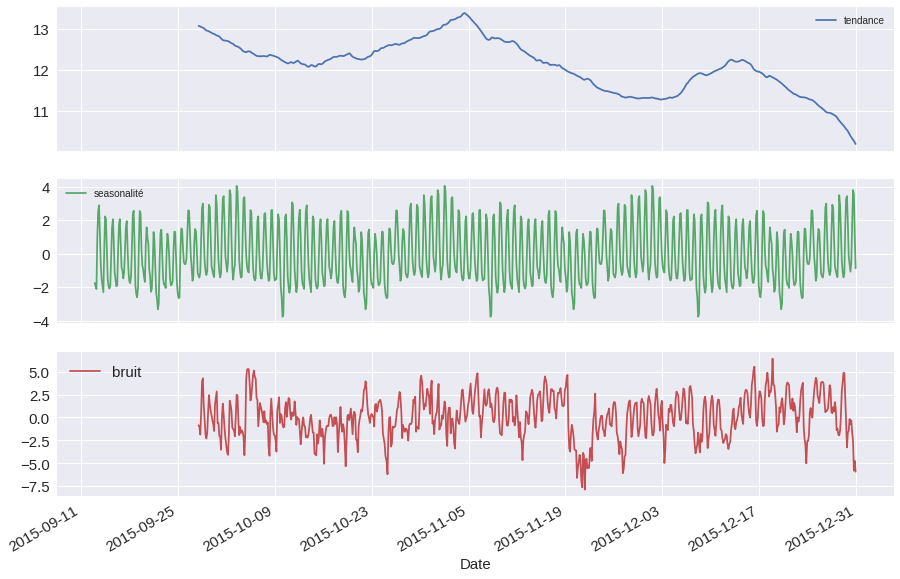

In [213]:
decomposition = sm.tsa.seasonal_decompose(meteo_train[["temperature"]].dropna(), freq = 240)

trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
decomposed.columns = ["tendance", "seasonalité", "bruit"]

ax = decomposed["2015"].plot(subplots = True, figsize = (15, 10), fontsize = 15)

plt.xlabel('Date', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

**Remarques**
* On peut remarquer la saisonnalité mensuelle et la tendance 



---



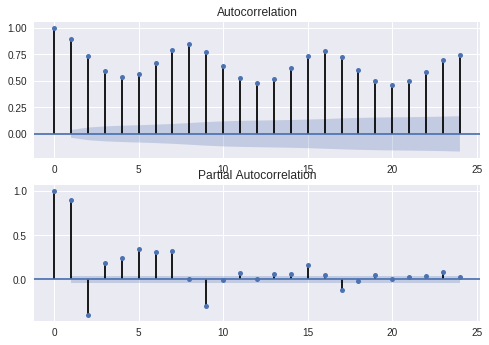

In [214]:
fig, axes = plt.subplots(2, 1)
fig = tsaplots.plot_acf(meteo_train["temperature"].dropna(), lags = 24, ax = axes[0])
fig = tsaplots.plot_pacf(meteo_train["temperature"].dropna(), lags = 24, ax = axes[1])
plt.show()



---



**Remarques**
* On peut voir qu'il y a une forte corrélation entre la température et la version lagged de celle ci, au même titre que la consommation.



---



#### Pression

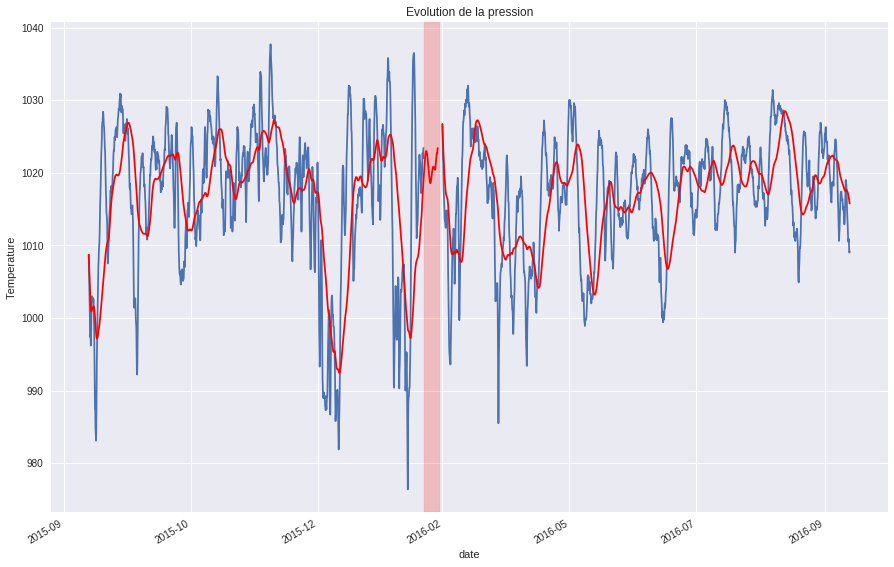

In [215]:
ax = meteo_train["pression"].plot(figsize = (15,10))

ax.axvspan("2016-02-21", "2016-02-29", color = "red"  , alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
ax.set_title("Evolution de la pression")

rolling = meteo_train["pression"].rolling(window = "7D").agg("mean")
rolling.plot(figsize = (15,10), color = "red")

plt.show()

**Remarques** :
* Il n'y pas une saisonnalité n'y une tendance évidente.
* Par contre la variabilité augmente en fin d'année 2015 puis dimuni



---



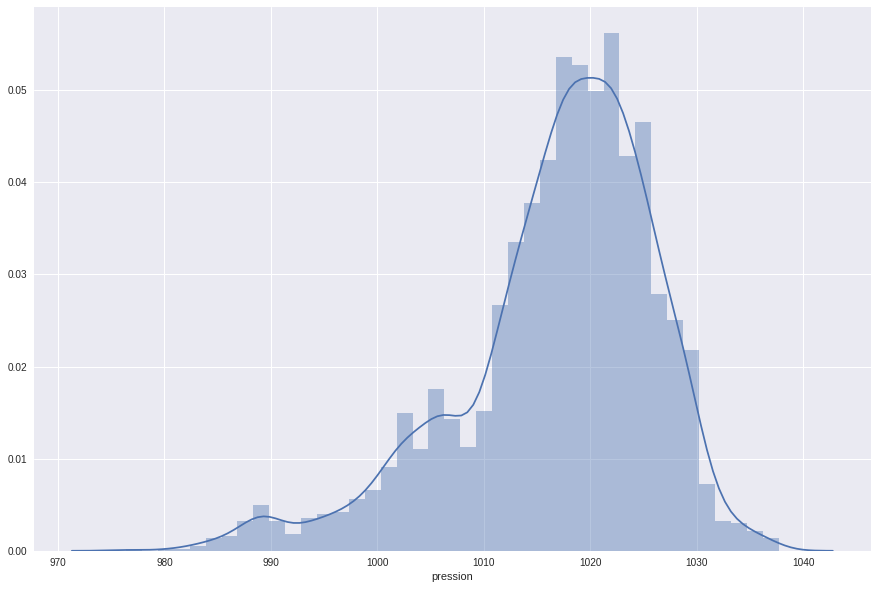

In [216]:
fig = plt.figure(figsize=(15,10))
ax = sns.distplot(meteo_train["pression"].dropna())
plt.show()

**Remarques**:
* La distribution n'est surement pas normale



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


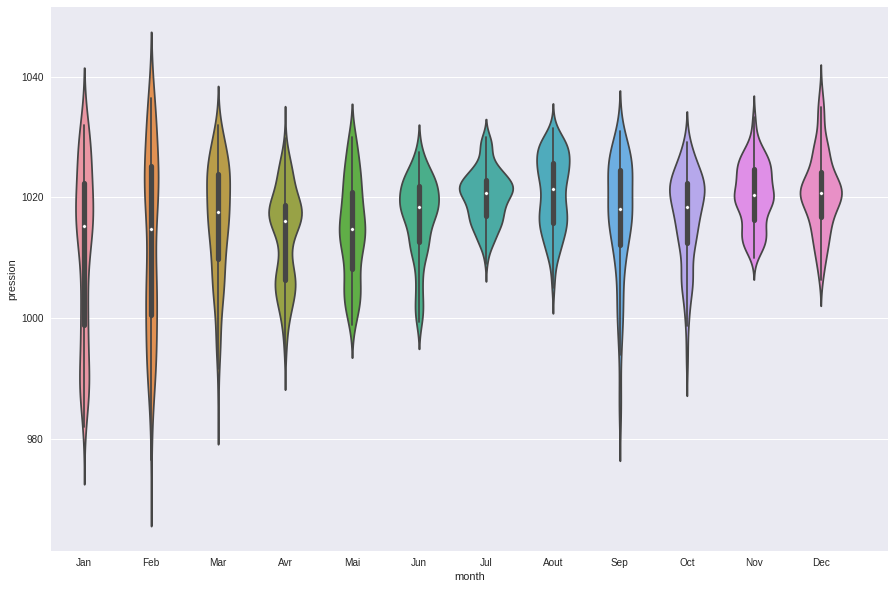

In [217]:
fig = plt.figure(figsize=(15,10))
ax = sns.violinplot(x = "month", y="pression", col = "day", data=meteo_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()



---



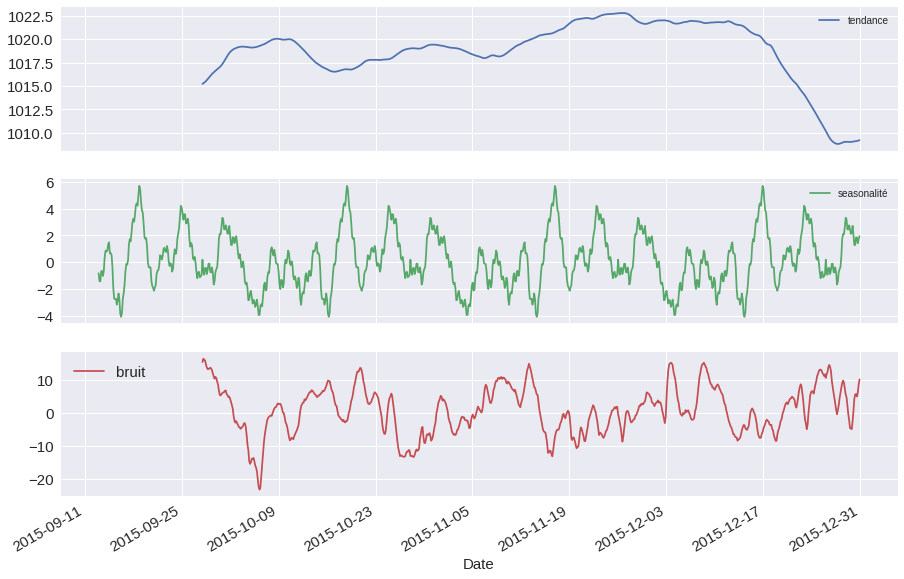

In [218]:
decomposition = sm.tsa.seasonal_decompose(meteo_train[["pression"]].dropna(), freq = 240)

# Extract the trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
decomposed.columns = ["tendance", "seasonalité", "bruit"]

# Plot the values of the df_decomposed DataFrame
ax = decomposed["2015"].plot(subplots = True, figsize = (15, 10), fontsize = 15)

# Specify axis labels
plt.xlabel('Date', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()



---



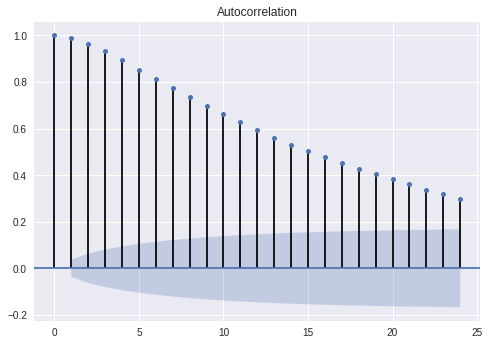

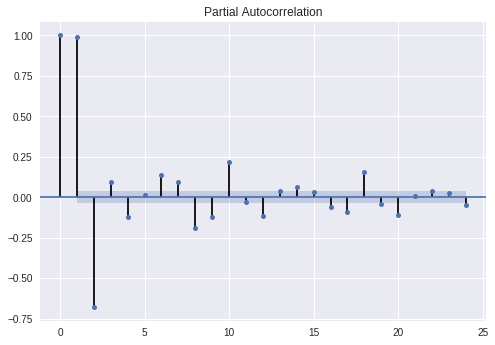

In [219]:
# Display the autocorrelation plot of of the temperature
fig = tsaplots.plot_acf(meteo_train["pression"].dropna(), lags = 24)

# Display the partail autocorrelation of the temperature
fig = tsaplots.plot_pacf(meteo_train["pression"].dropna(), lags = 24)

# Show plot
plt.show()



---



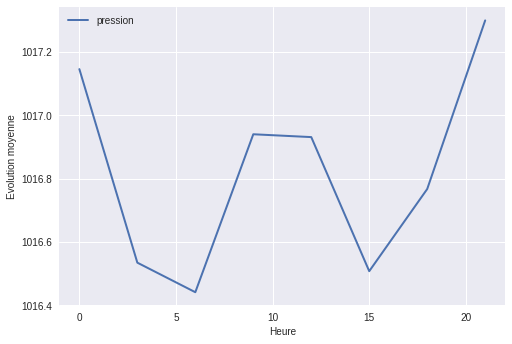

In [220]:
index_hour = meteo_train.index.hour

data_by_hour = meteo_train["pression"].groupby(index_hour).mean()

ax = data_by_hour.plot(fontsize = 10, linewidth = 2)

ax.set_xlabel('Heure', fontsize = 10)
ax.set_ylabel('Evolution moyenne', fontsize = 10)
ax.legend(fontsize = 10)
plt.show()



---



#### Humidité Relative

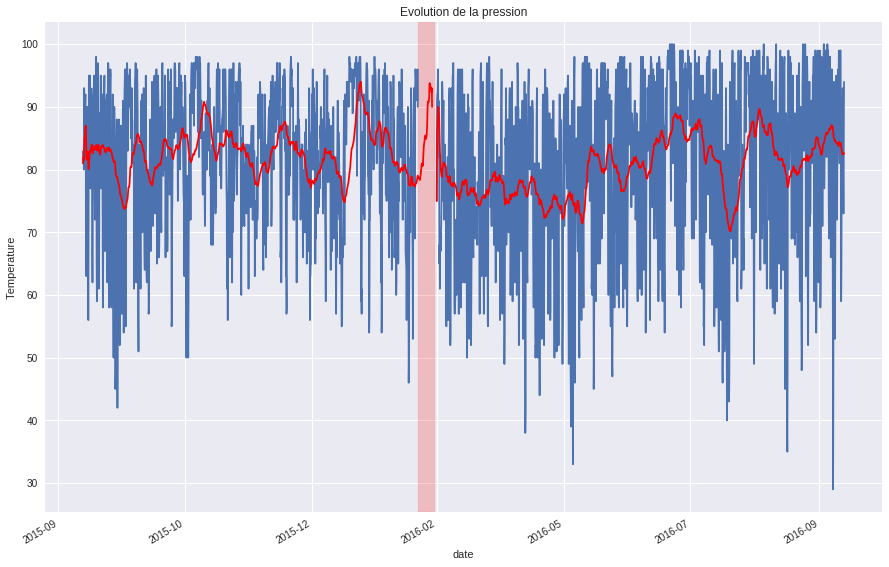

In [221]:
ax = meteo_train["humidite_relative"].plot(figsize = (15,10))

ax.axvspan("2016-02-21", "2016-02-29", color = "red"  , alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
ax.set_title("Evolution de la pression")

rolling = meteo_train["humidite_relative"].rolling(window = "7D").agg("mean")
rolling.plot(figsize = (15,10), color = "red")

plt.show()

**Remarques**:
* Ces données semblent être un marche aléatoire.



---



In [222]:
# Test de Dickey-Fulller
result = adfuller(meteo_train["humidite_relative"].dropna())
print("La p-value pour le test de Dickey Fuller est : ", result[1])

La p-value pour le test de Dickey Fuller est :  9.46356153172935e-13


**Remarques**:
* Il ne agit pas d'une marche aléatoire.



---



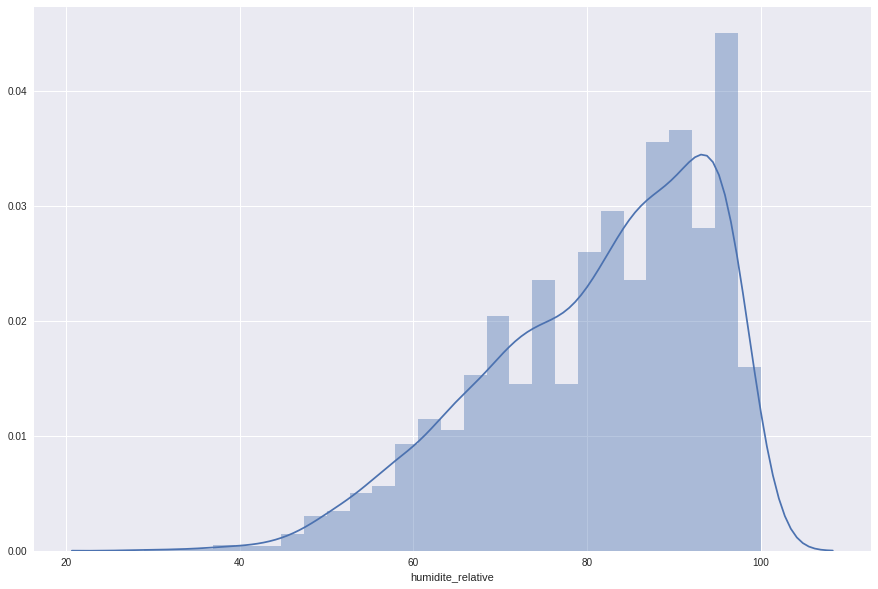

In [223]:
fig = plt.figure(figsize=(15,10))
ax = sns.distplot(meteo_train["humidite_relative"].dropna())
plt.show()



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


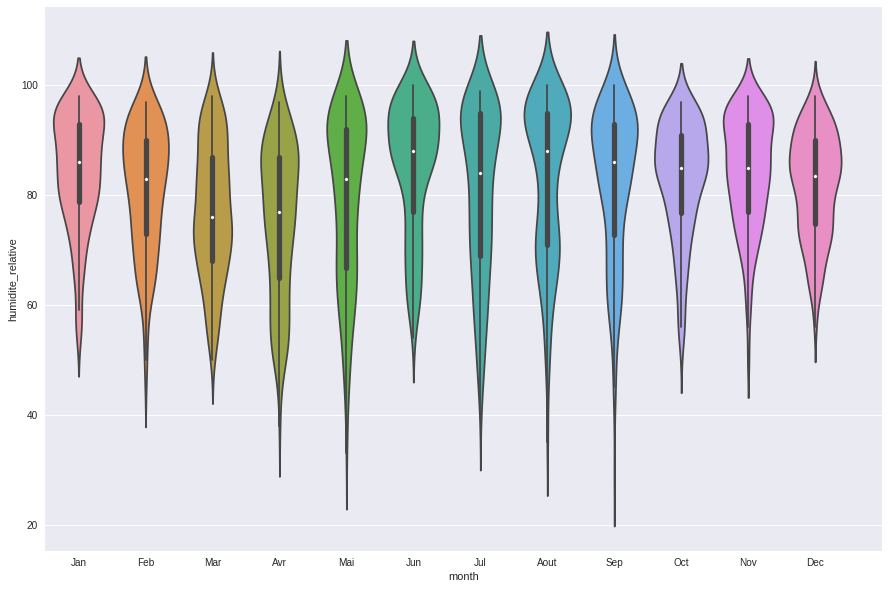

In [224]:
fig = plt.figure(figsize=(15,10))
ax = sns.violinplot(x = "month", y="humidite_relative", col = "day", data=meteo_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()



---



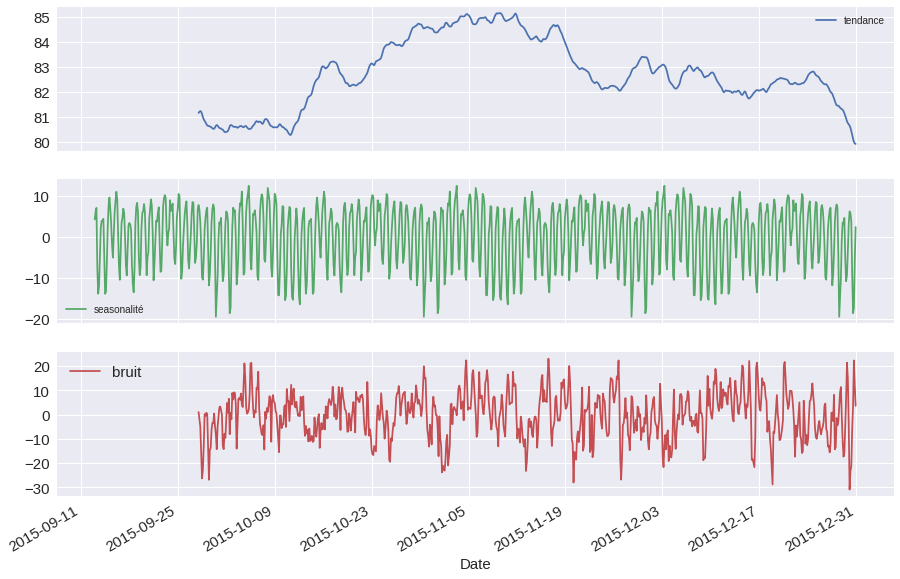

In [225]:
decomposition = sm.tsa.seasonal_decompose(meteo_train[["humidite_relative"]].dropna(), freq = 240)

# Extract the trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
decomposed.columns = ["tendance", "seasonalité", "bruit"]

# Plot the values of the df_decomposed DataFrame
ax = decomposed["2015"].plot(subplots = True, figsize = (15, 10), fontsize = 15)

# Specify axis labels
plt.xlabel('Date', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()



---



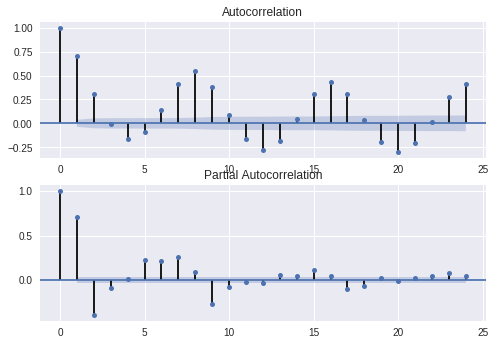

In [226]:
fig, axes = plt.subplots(2, 1)
fig = tsaplots.plot_acf(meteo_train["humidite_relative"].dropna(), lags = 24, ax = axes[0])
fig = tsaplots.plot_pacf(meteo_train["humidite_relative"].dropna(), lags = 24, ax = axes[1])
plt.show()



---



#### Point de rosé

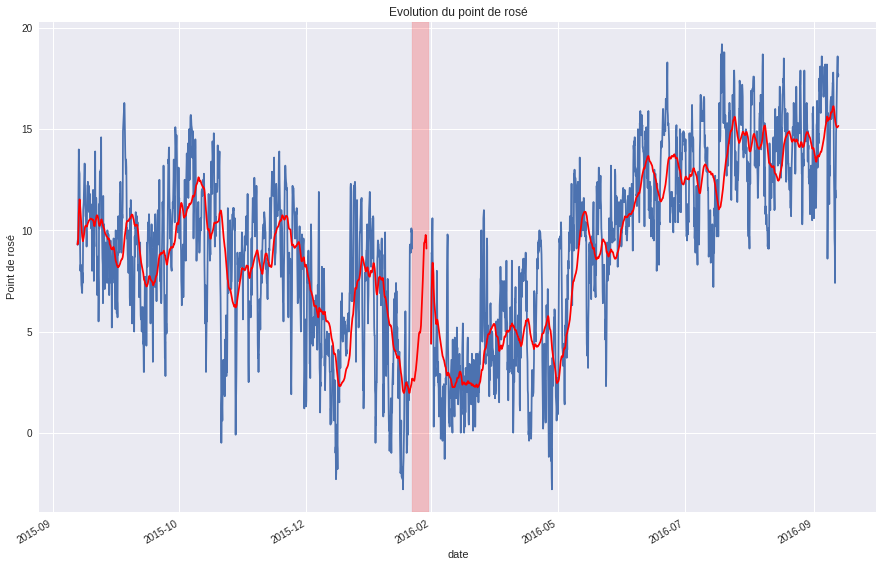

In [227]:
ax = meteo_train["point_rose"].plot(figsize = (15,10))

ax.axvspan("2016-02-21", "2016-02-29", color = "red"  , alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Point de rosé")
ax.set_title("Evolution du point de rosé")

rolling = meteo_train["point_rose"].rolling(window = "7D").agg("mean")
rolling.plot(figsize = (15,10), color = "red")

plt.show()



---



In [228]:
result = adfuller(meteo_train["humidite_relative"].dropna())
print("La p-value pour le test de Dickey Fuller est : ", result[1])

La p-value pour le test de Dickey Fuller est :  9.46356153172935e-13




---



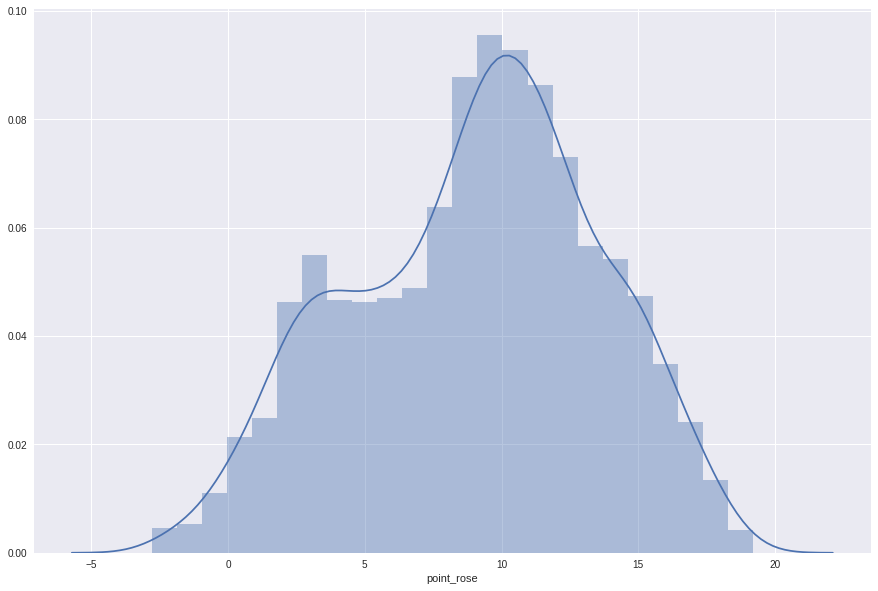

In [229]:
fig = plt.figure(figsize=(15,10))
ax = sns.distplot(meteo_train["point_rose"].dropna())
plt.show()



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


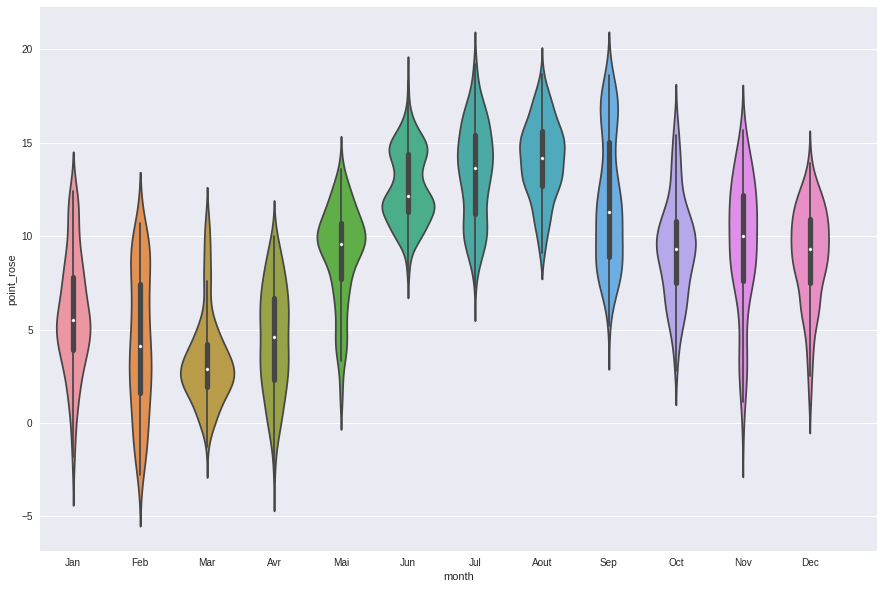

In [230]:
fig = plt.figure(figsize=(15,10))
ax = sns.violinplot(x = "month", y="point_rose", col = "day", data=meteo_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()



---



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


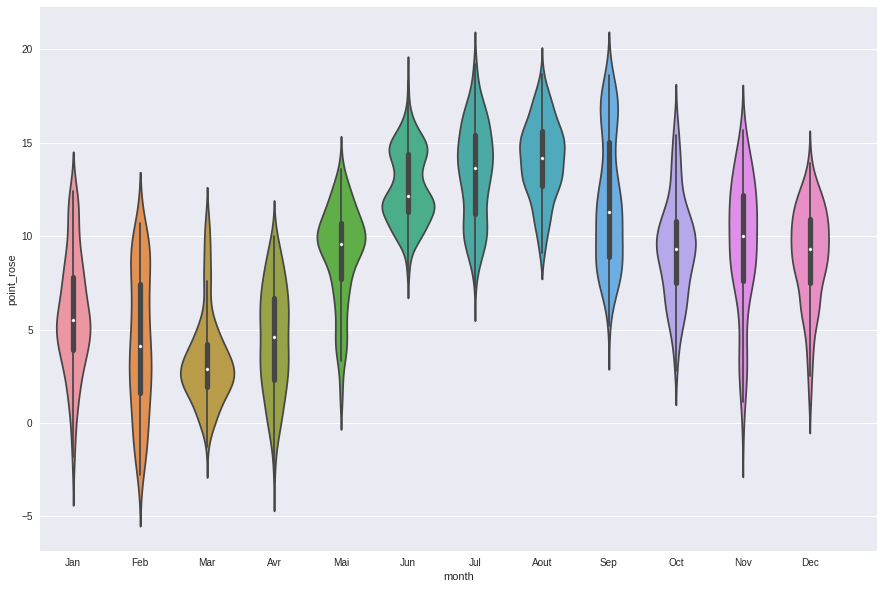

In [231]:
fig = plt.figure(figsize=(15,10))
ax = sns.violinplot(x = "month", y="point_rose", col = "day", data=meteo_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()



---



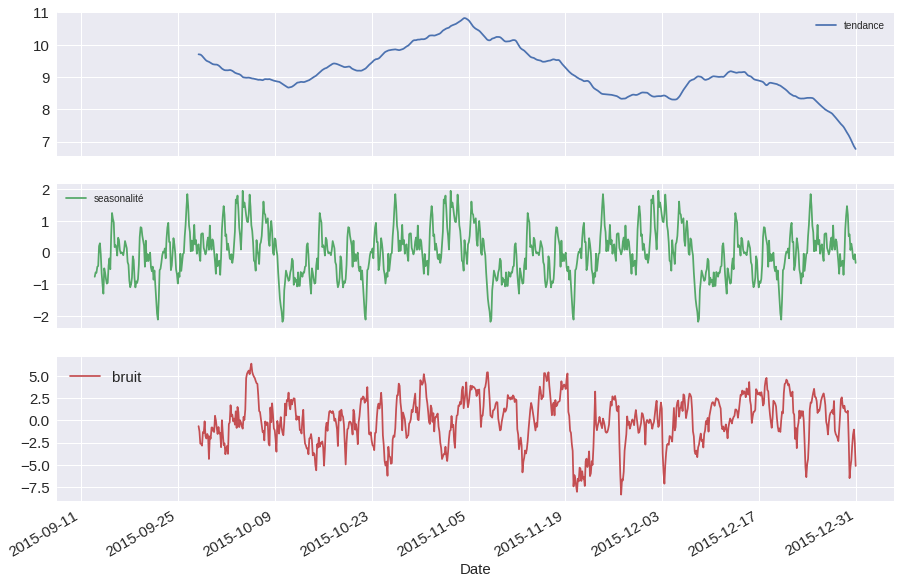

In [232]:
# Visualisation des composantes tendance, saisonalité, et bruit
decomposition = sm.tsa.seasonal_decompose(meteo_train[["point_rose"]].dropna(), freq = 240)

trend    = decomposition.trend
seasonal = decomposition.seasonal
noise    = decomposition.resid

decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
decomposed.columns = ["tendance", "seasonalité", "bruit"]

ax = decomposed["2015"].plot(subplots = True, figsize = (15, 10), fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()



---



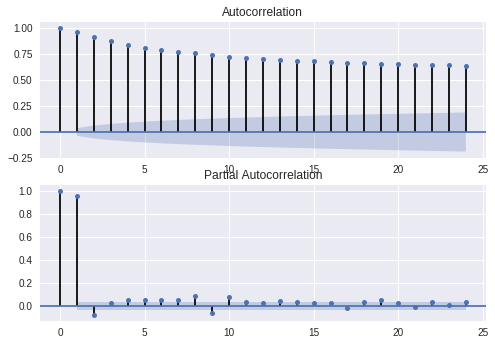

In [233]:
fig, axes = plt.subplots(2, 1)
fig = tsaplots.plot_acf(meteo_train["point_rose"].dropna(), lags = 24, ax = axes[0])
fig = tsaplots.plot_pacf(meteo_train["point_rose"].dropna(), lags = 24, ax = axes[1])
plt.show()



---



#### VIsibilite

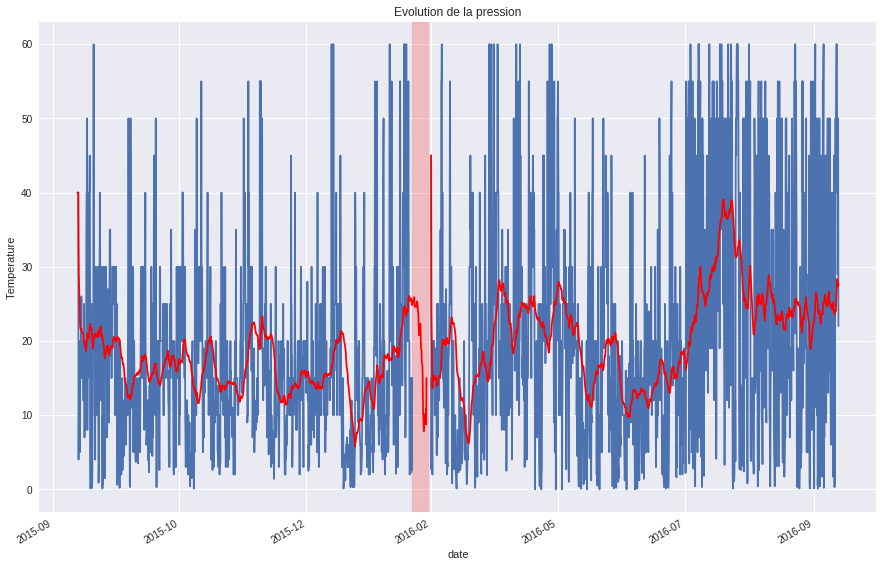

La p-value pour le test de Dickey Fuller est :  1.8145028630806615e-10


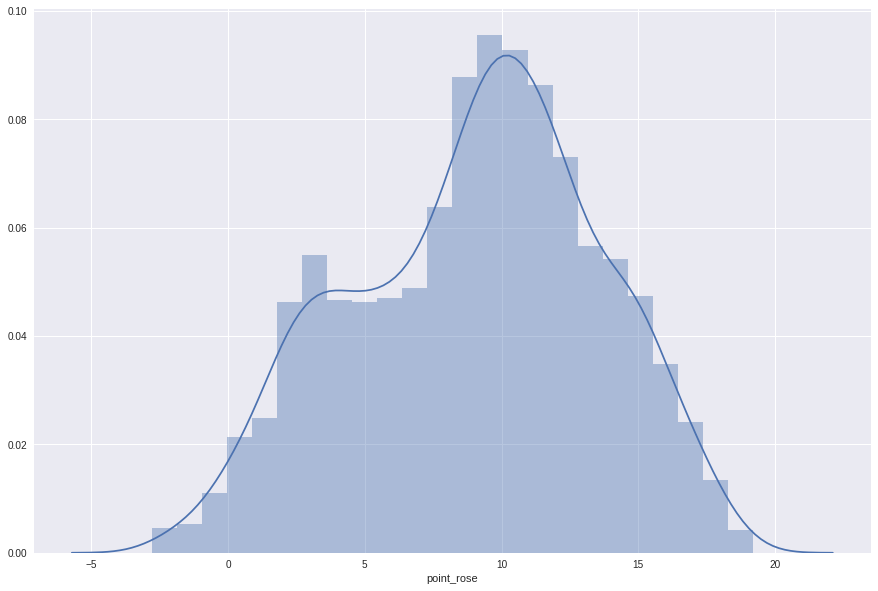

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


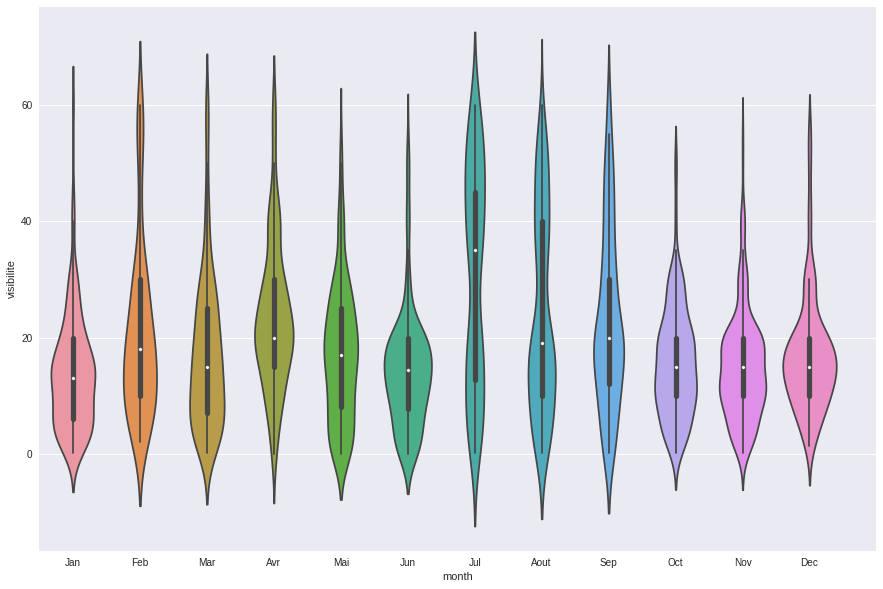

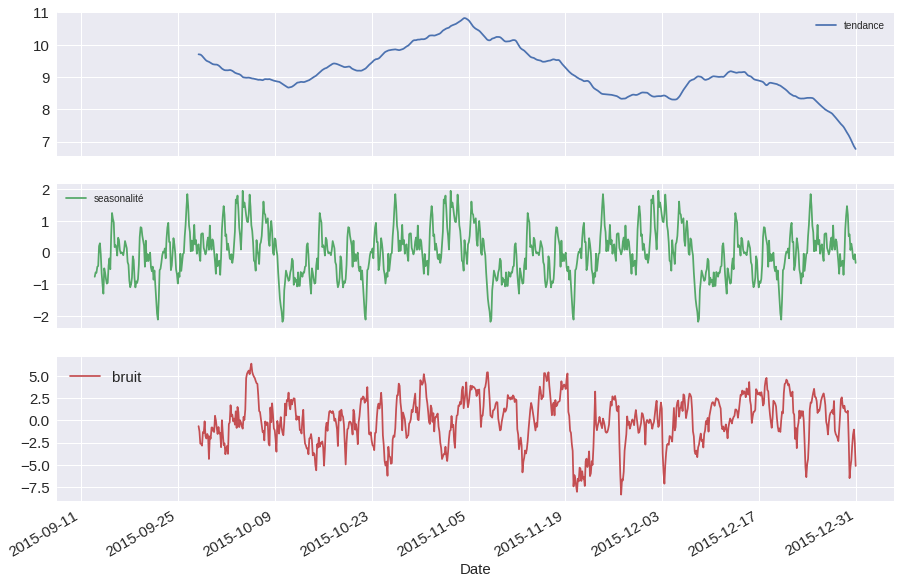

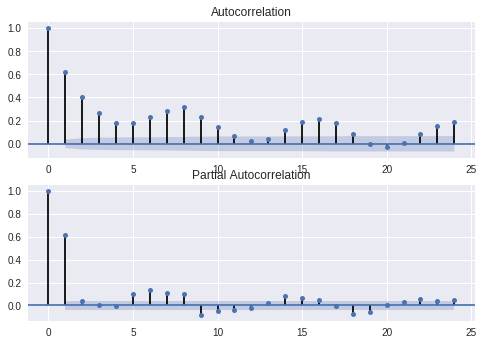

In [234]:
# Visualisation des données brute
ax = meteo_train["visibilite"].plot(figsize = (15,10))

ax.axvspan("2016-02-21", "2016-02-29", color = "red"  , alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
ax.set_title("Evolution de la pression")

rolling = meteo_train["visibilite"].rolling(window = "7D").agg("mean")
rolling.plot(figsize = (15,10), color = "red")

plt.show()

# Test de Dickey-Fulller
result = adfuller(meteo_train["visibilite"].dropna())
print("La p-value pour le test de Dickey Fuller est : ", result[1])

# Visualisation de la repartition
fig = plt.figure(figsize=(15,10))
ax = sns.distplot(meteo_train["point_rose"].dropna())
plt.show()

# Visualisation de la repartition par mois
fig = plt.figure(figsize=(15,10))
ax = sns.violinplot(x = "month", y="visibilite", col = "day", data=meteo_train)
plt.xticks(np.arange(0, 13), ["Jan", "Feb", "Mar", "Avr", "Mai", "Jun", "Jul", "Aout", "Sep", "Oct", "Nov", "Dec"])
plt.show()

# Visualisation des composantes tendance, saisonalité, et bruit
decomposition = sm.tsa.seasonal_decompose(meteo_train[["point_rose"]].dropna(), freq = 240)

trend    = decomposition.trend
seasonal = decomposition.seasonal
noise    = decomposition.resid

decomposed = pd.merge(trend, seasonal, left_index = True, right_index = True)
decomposed = pd.merge(decomposed, noise, left_index = True, right_index = True)
decomposed.columns = ["tendance", "seasonalité", "bruit"]

ax = decomposed["2015"].plot(subplots = True, figsize = (15, 10), fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# Visualisation de l'autocorrélation et de l'autocorrélation partielle
fig, axes = plt.subplots(2, 1)
fig = tsaplots.plot_acf(meteo_train["visibilite"].dropna(), lags = 24, ax = axes[0])
fig = tsaplots.plot_pacf(meteo_train["visibilite"].dropna(), lags = 24, ax = axes[1])
plt.show()



---



#### Direction du vent

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


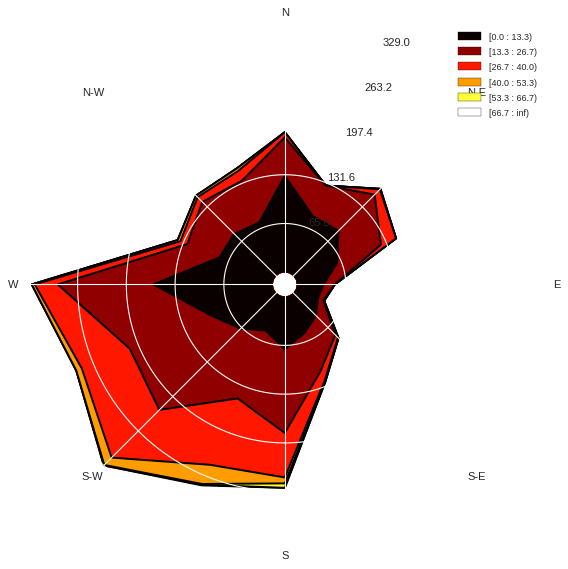

In [235]:
ax = WindroseAxes.from_ax()
ax.contourf(meteo_train.vent_direction, meteo_train.vent_moyen, cmap=cm.hot)
ax.contour(meteo_train.vent_direction, meteo_train.vent_moyen, colors='black')
ax.set_legend(loc= "best")
plt.show()

# Préprocessing

In [ ]:
# Splitter les données par année
conso_train_2015 = conso_train["2015"].drop(["hour", "day", "month"], axis = 1)
conso_train_2016 = conso_train["2016"].drop(["hour", "day", "month"], axis = 1)
meteo_train_2015 = meteo_train["2015"].drop(["hour", "day", "month"], axis = 1)
meteo_train_2016 = meteo_train["2016"].drop(["hour", "day", "month"], axis = 1)



---



In [ ]:
# Reajuster des dates pour les données de consommation
conso_train_2015.index = conso_train_2015.index + pd.Timedelta(seconds = 1)

# Reajuster des dates pour les données de météo
meteo_train_2015 = meteo_train_2015.append(meteo_train_2016.iloc[0, :])



---



In [ ]:
# Interpoler les données météo à la maille horaire
meteo_train_2015_resampled = meteo_train_2015.resample("H").interpolate().iloc[1:-1]
meteo_train_2016_resampled = meteo_train_2016.resample("H").interpolate()
conso_train_2015_resampled = conso_train_2015.resample("H").interpolate()
conso_train_2016_resampled = conso_train_2016.resample("H").interpolate()



---



In [ ]:
# Reajuster des dates pour les données de météo de 2016
conso_train_2016_resempled = conso_train_2016.iloc[:-3]



---



In [240]:
# Supprimer la tranche horaire de données manquantes
meteo_train_2016_resampled.drop(meteo_train_2016_resampled["2016-02-29"].index, inplace = True)
meteo_train_2016_resampled.drop(meteo_train_2016_resampled["2016-02-21":"2016-02-28"].index, inplace = True)
conso_train_2016_resempled.drop(conso_train_2016_resempled["2016-02-21":"2016-02-28"].index, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until




---



In [241]:
# Checher si les tailles correspondent
print("2015 lenght match ?", len(meteo_train_2015_resampled) == len(conso_train_2015_resampled))
print("2016 lenght match ?", len(meteo_train_2016_resampled) == len(conso_train_2016_resempled))

2015 lenght match ? True
2016 lenght match ? True




---



In [ ]:
# Fusionner les données qui avaient été Splitté
meteo_train_resampled = pd.concat([meteo_train_2015_resampled, meteo_train_2016_resampled])
conso_train_resampled = pd.concat([conso_train_2015_resampled, conso_train_2016_resempled])



---



In [ ]:
# Supprimer la donnée de neige qui étaient null
meteo_train_resampled.drop("neige", axis = 1, inplace = True)



---



In [ ]:
X = meteo_train_resampled.values
y = conso_train_resampled.values



---



In [ ]:
# Fusionner les données pour appliquer la fonction de lag
data_train = np.c_[X, y]



---



In [ ]:
# Aplliquer la fonction de lag avec 73, qui correspond à 3 jours
data_train_reframed = series_to_supervised(data_train, meteo_train_resampled.index, 73, 1)



---



In [ ]:
# Récuperer la variable à expliquer
X = data_train_reframed.iloc[:, :-1]
y = data_train_reframed.iloc[:, -1]



---



In [ ]:
# Extraire le jour et l'heure qui serviront dans la prédiction
X["hour"] = X.index.hour
X["day"]  = X.index.weekday



---



In [ ]:
# Distinguer les variables catégorielles et les variables numeriques
cat_features = ["hour", "day"]
num_features = X.drop(["hour", "day"], axis = 1).columns.values



---



In [ ]:
# Créer une pipeline pour les variables numeriques
num_pipeline = Pipeline([
	("selector", DataFrameSelector(num_features)),
	("imputer", Imputer(strategy = "median"))
])

# Créer une pipeline pour les variables catégorielles
cat_pipeline = Pipeline([
	("selector", DataFrameSelector(cat_features)),
	("imputer", OneHotEncoder(sparse = False))
])

# Créer une pipeline finale pour fusionner les données
full_pipeline = FeatureUnion([
	("cat_pipeline", cat_pipeline),
	("num_pipeline", num_pipeline)
])

# Transformer les données météo
X_prep = full_pipeline.fit_transform(X)



---



In [ ]:
# Choisir 329 jours d'apprentissage, 16 jours de validation, et 8 jours de test
n_train = 329 * 24
n_valid = 345 * 24

# Splitter en apprentissage, validation et test
X_train = X_prep[:n_train, :]
X_valid = X_prep[n_train:n_valid, :]
X_test_ = X_prep[n_valid:, :]

y_train = y[:n_train]
y_valid = y[n_train:n_valid:]
y_test_ = y[n_valid:]

In [252]:
print(f"Nombre de jours d'entrainement : {X_train.shape[0] / 24}")
print(f"Nombre de jours de validation  : {X_valid.shape[0] / 24}")
print(f"Nombre de jours de test        : {X_test_.shape[0] / 24}")

Nombre de jours d'entrainement : 329.0
Nombre de jours de validation  : 16.0
Nombre de jours de test        : 8.833333333333334


# Modélisation

## Réseau de neuronnes

In [170]:
X_train_n = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_valid_n = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

X_test_n_ = X_test_.reshape((X_test_.shape[0], 1, X_test_.shape[1]))

print(X_train_n.shape, y_train.shape, X_test_n_.shape, y_test_.shape, X_valid_n.shape, y_valid.shape)

(7896, 1, 844) (7896,) (212, 1, 844) (212,) (384, 1, 844) (384,)


Train on 7896 samples, validate on 384 samples
Epoch 1/50
 - 5s - loss: 734.3965 - val_loss: 465.5274
Epoch 2/50
 - 4s - loss: 680.8279 - val_loss: 412.8076
Epoch 3/50
 - 4s - loss: 628.5754 - val_loss: 360.8365
Epoch 4/50
 - 4s - loss: 576.7325 - val_loss: 309.0955
Epoch 5/50
 - 4s - loss: 525.0513 - val_loss: 257.4675
Epoch 6/50
 - 4s - loss: 473.4839 - val_loss: 206.3264
Epoch 7/50
 - 4s - loss: 423.6953 - val_loss: 163.3574
Epoch 8/50
 - 4s - loss: 379.7020 - val_loss: 131.0689
Epoch 9/50
 - 4s - loss: 341.8935 - val_loss: 112.3944
Epoch 10/50
 - 4s - loss: 311.7573 - val_loss: 103.8246
Epoch 11/50
 - 4s - loss: 288.8346 - val_loss: 103.6696
Epoch 12/50
 - 4s - loss: 271.8448 - val_loss: 107.6632
Epoch 13/50
 - 4s - loss: 259.7341 - val_loss: 113.9526
Epoch 14/50
 - 4s - loss: 251.2211 - val_loss: 122.2421
Epoch 15/50
 - 4s - loss: 244.9055 - val_loss: 131.6526
Epoch 16/50
 - 4s - loss: 240.1432 - val_loss: 141.2588
Epoch 17/50
 - 4s - loss: 236.5152 - val_loss: 150.5854
Epoch 18/5

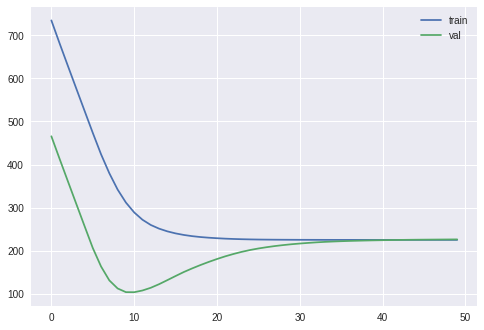

In [171]:
# le reseau sequentiel
model = Sequential()
model.add(LSTM(844, input_shape=(X_train_n.shape[1], X_train_n.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
              
history = model.fit(X_train_n, y_train, epochs=50, batch_size=32, validation_data=(X_valid_n, y_valid), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

**Remarque**:
* On peut remarquer que le modèle LSMT n'arrive pas à donner de très bon resultats.
* D'une part quand on ne met pas assez d'époques, il y a un sous apprentissage, et une fois qu'on n'en met un peu plus, il y sous apprentissage.
* En génerale, l'erreur ne va pas en dessous de 100Kw, ce qui n'est pas acceptable.

## Forêt aléatoire

Mean absolute error 20.729861111098693


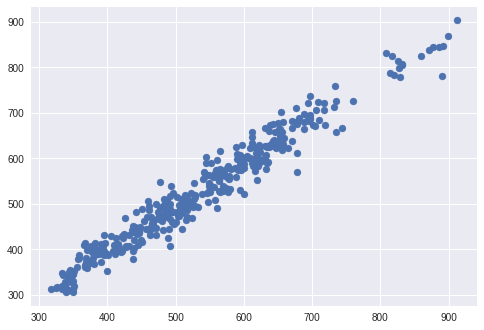

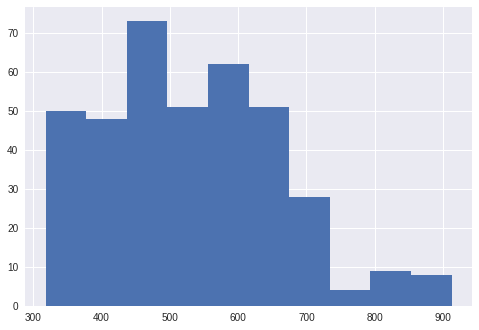

In [259]:
rnd_reg = RandomForestRegressor()

rnd_reg.fit(X_train, y_train)

y_test_pred = xgb_reg.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

plt.scatter(y_test_pred, y_test_)
plt.show()

plt.hist(y_test_pred)
plt.show()



---



In [261]:
param_grid = {
	"n_estimators": [100, 200],
  "max_depth"   : [None, 100, 200]
}

grid_search = GridSearchCV(rnd_reg, param_grid = param_grid, scoring = "neg_mean_absolute_error", cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

grid_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] bootstrap=True, max_depth=10, n_estimators=10 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=10, total=  14.8s
[CV] bootstrap=True, max_depth=10, n_estimators=10 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s


[CV] .... bootstrap=True, max_depth=10, n_estimators=10, total=  14.5s
[CV] bootstrap=True, max_depth=10, n_estimators=10 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=10, total=  14.6s
[CV] bootstrap=True, max_depth=10, n_estimators=50 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=50, total= 1.2min
[CV] bootstrap=True, max_depth=10, n_estimators=50 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=50, total= 1.2min
[CV] bootstrap=True, max_depth=10, n_estimators=50 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=50, total= 1.2min
[CV] bootstrap=True, max_depth=10, n_estimators=100 ..................
[CV] ... bootstrap=True, max_depth=10, n_estimators=100, total= 2.4min
[CV] bootstrap=True, max_depth=10, n_estimators=100 ..................
[CV] ... bootstrap=True, max_depth=10, n_estimators=100, total= 2.4min
[CV] bootstrap=True, max_depth=10, n_estimators=100 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 112.7min finished


Mean absolute error 19.387200520817846


{'bootstrap': True, 'max_depth': 100, 'n_estimators': 100}



---



## Extra forêt aléatoire

Mean absolute error 21.695377604124616


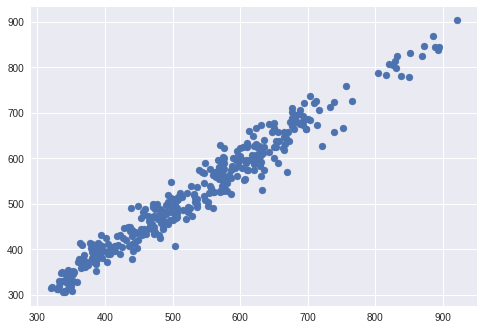

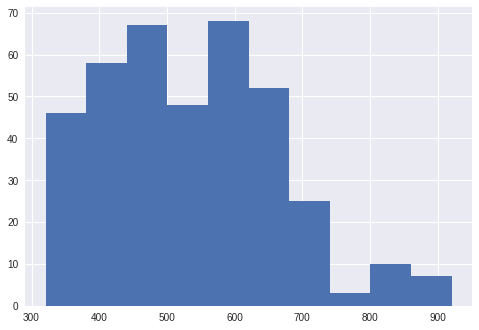

In [266]:
ext_reg = ExtraTreesRegressor()

ext_reg.fit(X_train, y_train)

y_test_pred = xgb_reg.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

plt.scatter(y_test_pred, y_test_)
plt.show()

plt.hist(y_test_pred)
plt.show()



---



In [263]:
param_grid = {
	"n_estimators": [10, 50, 100],
  "max_depth"   : [10, 50, 100],
   "bootstrap"  : [True, False]
}

grid_search = GridSearchCV(ext_reg, param_grid = param_grid, scoring = "neg_mean_absolute_error", cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

grid_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] bootstrap=True, max_depth=10, n_estimators=10 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=10, total=   2.7s
[CV] bootstrap=True, max_depth=10, n_estimators=10 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] .... bootstrap=True, max_depth=10, n_estimators=10, total=   2.6s
[CV] bootstrap=True, max_depth=10, n_estimators=10 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=10, total=   2.7s
[CV] bootstrap=True, max_depth=10, n_estimators=50 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=50, total=  13.1s
[CV] bootstrap=True, max_depth=10, n_estimators=50 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=50, total=  13.0s
[CV] bootstrap=True, max_depth=10, n_estimators=50 ...................
[CV] .... bootstrap=True, max_depth=10, n_estimators=50, total=  13.3s
[CV] bootstrap=True, max_depth=10, n_estimators=100 ..................
[CV] ... bootstrap=True, max_depth=10, n_estimators=100, total=  26.2s
[CV] bootstrap=True, max_depth=10, n_estimators=100 ..................
[CV] ... bootstrap=True, max_depth=10, n_estimators=100, total=  25.8s
[CV] bootstrap=True, max_depth=10, n_estimators=100 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 26.5min finished


Mean absolute error 19.577300347200833


{'bootstrap': False, 'max_depth': 50, 'n_estimators': 100}



---



## Extreme gradient boosting

Mean absolute error 20.365278032076173


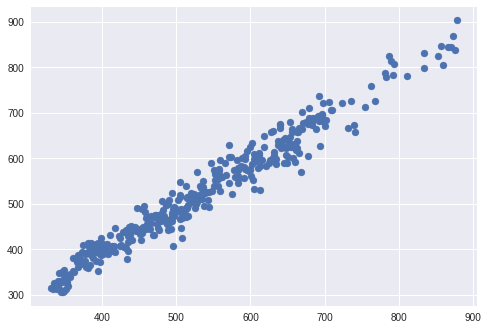

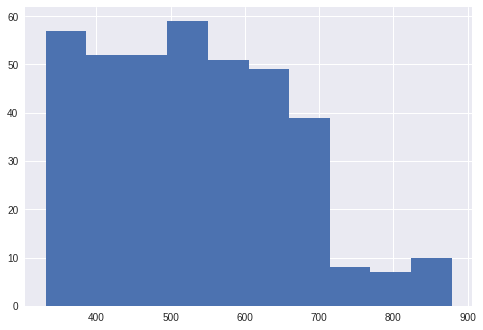

In [264]:
xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(X_train, y_train,
           eval_set = [(X_train, y_train), (X_valid, y_valid)],
            verbose = 11
)

y_test_pred = xgb_reg.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

plt.scatter(y_test_pred, y_test_)
plt.show()

plt.hist(y_test_pred)
plt.show()



---



In [269]:
param_grid = {
  'max_depth'       : [2, 5, 10],
  'min_child_weight': [10, 15, 20],
  'colsample_bytree': [1, 2, 4],
  'n_estimators'    : [100, 200, 500],
  'learning_rate'   : [.07, 0.09, 0.1]
}

grid_search = GridSearchCV(xgb_reg, param_grid, scoring = "neg_mean_absolute_error", cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

grid_search.best_params_

# Mean absolute error 18.40952905017822
# {'colsample_bytree': 1,
# 'learning_rate': 0.07,
# 'max_depth': 5,
# 'min_child_weight': 10,
# 'n_estimators': 100}

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=10 
[CV]  colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=10, total=   0.6s
[CV] colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=10, total=   0.6s
[CV] colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=10 
[CV]  colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=10, total=   0.6s
[CV] colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=50 
[CV]  colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=50, total=   1.7s
[CV] colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=50 
[CV]  colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=50, total=   1.7s
[CV] colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=50 
[CV]  colsample_bytree=0.3, learning_rate=0.03, max_depth=2, min_child_weight=2, n_estimators=50, total=   1.7s
[CV] colsample_bytree=0.3, learning_rate=0.03, max_d

[Parallel(n_jobs=1)]: Done 729 out of 729 | elapsed: 105.1min finished


Mean absolute error 18.40952905017822


{'colsample_bytree': 1,
 'learning_rate': 0.07,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 100}



---



## Boosting

In [285]:
xgb_reg = xgb.XGBRegressor(
  max_depth = 5,
  n_estimators = 100,
  learning_rate = 0.07,
  colsample_bytree = 1,
  min_child_weight = 10
)

ada_reg = AdaBoostRegressor(xgb_reg, n_estimators = 50, learning_rate = 1, loss = "linear")

ada_reg.fit(X_train, y_train)

y_test_pred = xgb_reg.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

plt.scatter(y_test_pred, y_test_)
plt.show()

plt.hist(y_test_pred)
plt.show()

KeyboardInterrupt: ignored



---



In [ ]:
param_grid = {
  'n_estimators'    : [10, 50, 100],
  'learning_rate'   : [.001, 0.1, 1],
  'loss'            : ["linear", "square", "exponential"]
}

grid_search = GridSearchCV(ada_reg, param_grid, scoring = "neg_mean_absolute_error", cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

grid_search.best_params_



---



## Stacking

Mean absolute error 19.418802083324042


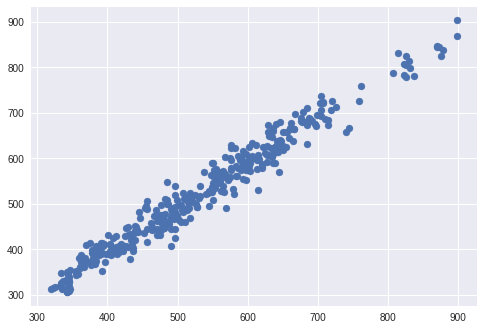

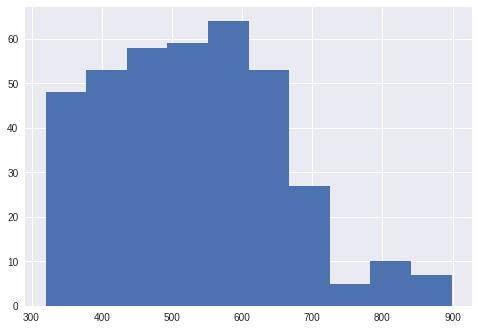

In [175]:
bag_reg = BaggingRegressor(xgb_reg, bootstrap = False)

bag_reg.fit(X_train, y_train)

y_test_pred = xgb_reg.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

plt.scatter(y_test_pred, y_test_)
plt.show()

plt.hist(y_test_pred)
plt.show()



---



In [ ]:
param_grid = {
  'n_estimators'    : [10, 50, 100],
  'max_samples'     : [1, 2, 3],
  'max_features'    : [1, 2, 3

grid_search = GridSearchCV(bag_reg, param_grid, scoring = "neg_mean_absolute_error", cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test_)

print(f"Mean absolute error {mean_absolute_error(y_test_pred, y_test_)}")

grid_search.best_params_



---



# Prédiction

### Préprocessing

In [ ]:
# Interpoler les données de prévision
meteo_previ = meteo_previ.append(meteo_train.iloc[-1, :]).sort_index()

meteo_previ_resampled = meteo_previ.resample("H").interpolate().iloc[:-1, :]

**Remarques**:
* Les données de prévision commencent...



---



In [ ]:
# Creer les donnéses de consommation à prédire
conso_previ = pd.DataFrame(np.zeros((len(meteo_previ_resampled), 1)), columns = ["puissance"], index = meteo_previ_resampled.index)

conso_previ["puissance"].iloc[:4] = conso_train["puissance"].iloc[-4:].values

**Remarques**:
* En vu de faire prédictions, on crée un dataFrame vide qu'on remplira au fur et à mésure.
* On rajoute la dernière donnée de consommation car celle ci correspond au 13/09/16 00h00, et nos prédictions sont supposées débuter à 00h00.



---



In [ ]:
# Concatener toutes les données
conso_total = pd.concat([conso_train_resampled, conso_previ.iloc[1:, :]])
meteo_total = pd.concat([meteo_train_resampled, meteo_previ_resampled.iloc[1:, :]])

**Remarques**:
* On concatene les données de consommmation disponible et celle à prédire d'une part et les données météo d'autre part.



---



In [ ]:
meteo_total = meteo_total.drop(["neige", "hour", "day", "month"], axis = 1)



---



In [ ]:
# Mettre sous la forme avec des lag
X_total = meteo_total.values
y_total = conso_total.values

data_total = np.c_[X_total, y_total]
data_total_reframed = series_to_supervised(data_total, meteo_total.index, 73, 1)

**remarques**:
* On concatene toutes les données afin de les mettre sous la forme supervisé.

### Prédiction avec jeu de validation

In [ ]:
X_train = data_total_reframed[:"2016-09-01"].iloc[:, :-1]
y_train = data_total_reframed[:"2016-09-01"].iloc[:, -1]

X_valid = data_total_reframed["2016-09-02":"2016-09-12"].iloc[:, :-1]
y_valid = data_total_reframed["2016-09-02":"2016-09-12"].iloc[:, -1]

**Remarques**:
* On choisi de prendre la periode allant du début jusqu'au 2016-09-01 pour période d'entrainement
* On choisi de prendre la période allant du 2016-09-01 au 2016-09-12 (date de fin des dconsommation disponible) pour le test



---



In [ ]:
# Rajouter les varibles heure et jour
X_train["hour"] = X_train.index.hour
X_train["day"] = X_train.index.weekday

X_valid["hour"] = X_valid.index.hour
X_valid["day"] = X_valid.index.weekday



---



In [ ]:
# Extraire les version laggé de la variable consommation (variable 11)
var11 = X_valid.columns[X_valid.columns.str.contains("var11")]

conso_train_prec = X_train[var11]
conso_valid_prec = X_valid[var11]



---



In [ ]:
# Mettre les version laggé de la variable consommation en fin du DataFrame
X_train.drop(var11, axis = 1, inplace = True)
X_valid.drop(var11, axis = 1, inplace = True)

X_train = X_train.join(conso_train_prec)
X_valid = X_valid.join(conso_valid_prec)



---



In [ ]:
cat_features = ["hour", "day"]
num_features = X_valid.drop(["hour", "day"], axis = 1).columns.values

num_pipeline = Pipeline([
	("selector", DataFrameSelector(num_features)),
	("imputer", Imputer(strategy = "median"))
])

cat_pipeline = Pipeline([
	("selector", DataFrameSelector(cat_features)),
	("imputer", OneHotEncoder(sparse = False))
])

full_pipeline = FeatureUnion([
	("cat_pipeline", cat_pipeline),
	("num_pipeline", num_pipeline)
])

X_train_prep = full_pipeline.fit_transform(X_train)

X_valid_prep = full_pipeline.transform(X_valid)

In [282]:
X_train_prep[:4, -4:]

array([[702.66666667, 716.        , 575.83333333, 499.        ],
       [716.        , 575.83333333, 499.        , 439.83333333],
       [575.83333333, 499.        , 439.83333333, 389.5       ],
       [499.        , 439.83333333, 389.5       , 368.16666667]])

In [283]:
y_train.head().values.reshape(-1, 1)

array([[439.83333333],
       [389.5       ],
       [368.16666667],
       [353.83333333],
       [370.16666667]])



---



Mean absolute error 17.41447947564597


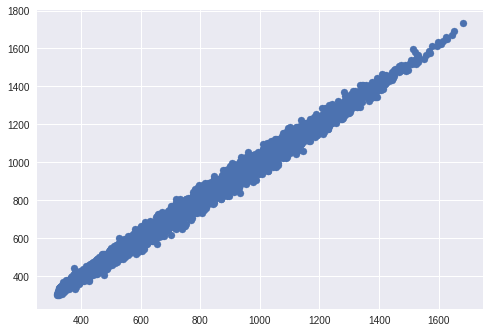

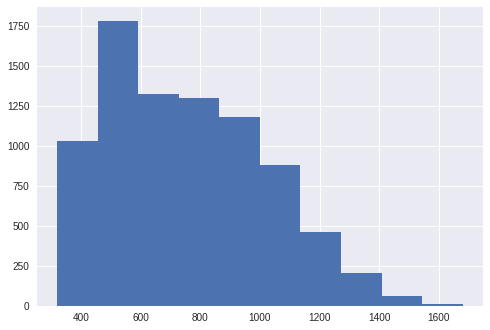

In [298]:
xgb_reg.fit(X_train_prep, y_train)

y_train_pred = xgb_reg.predict(X_train_prep)

print(f"Mean absolute error {mean_absolute_error(y_train_pred, y_train)}")

plt.scatter(y_train_pred, y_train)
plt.show()

plt.hist(y_train_pred)
plt.show()



---



In [ ]:
y_valid_pred = pd.DataFrame(np.zeros((len(y_valid), 1)), columns = ["puissance"], index = y_valid.index)

y_valid_pred.iloc[0, 0] = y_valid.iloc[0]



---



In [300]:
y_valid_pred = pd.DataFrame(np.zeros((len(y_valid), 1)), columns = ["puissance"], index = y_valid.index)

y_valid_pred.iloc[0, 0] = y_valid.iloc[0]

data_valid_total = np.c_[X_valid_prep, y_valid_pred.values]

data_valid_total[:4, -4:]

array([[443.33333333, 600.        , 537.66666667, 470.        ],
       [600.        , 537.66666667, 470.        ,   0.        ],
       [537.66666667, 470.        , 393.33333333,   0.        ],
       [470.        , 393.33333333, 361.83333333,   0.        ]])

**Remarques**:
* On peut remarquer les données à predire en 0



---



Mean absolute error 35.43383838382197


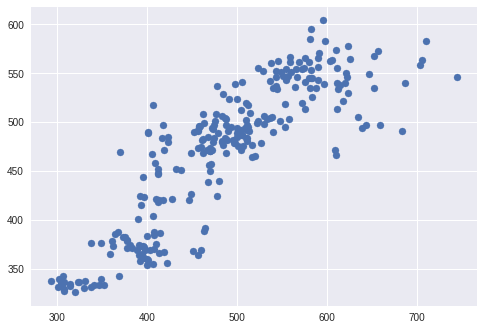

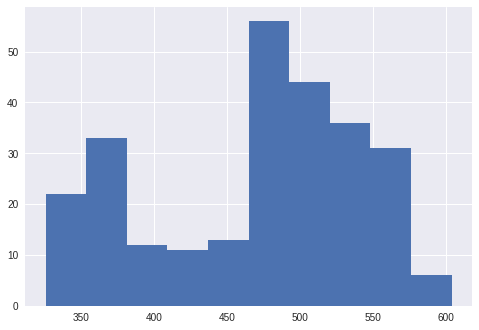

In [302]:
for i in range(len(data_valid_total)):
	
	if data_valid_total[i, -1] == 0:
		
		data = data_valid_total[i, :-1].reshape(1, -1)
		
		y_pred = xgb_reg.predict(data)
		
		n_prop = 73 if len(data_valid_total) - i > 73 else len(data_valid_total) - i
		
		j = data_valid_total.shape[1] - 1
		
		for k in range(n_prop):
			
			data_valid_total[k + i, j] = y_pred
			
			j = j - 1

print(f"Mean absolute error {mean_absolute_error(y_valid, data_valid_total[:, -1])}")  # 35.73143939390947
      
plt.scatter(y_valid, data_valid_total[:, -1])
plt.show()

plt.hist(data_valid_total[:, -1])
plt.show()

**Remarque**:
* On parcours chaque ligne de donnée, et on predit la consommation à cette heure.
* Cette donnée prédite est propagée sur les ligne en déssous, car le modèle utilise la consommation (prédite) précedente pour estimer celle de l'heure courante



---



### Prédiction finale

In [ ]:
# Splitter les donnée d'entrainement et les donnée de prédiction
X_train = data_total_reframed[:"2016-09-12"].iloc[:, :-1]
y_train = data_total_reframed[:"2016-09-12"].iloc[:, -1]

X_previ = data_total_reframed["2016-09-13":].iloc[:, :-1]
y_previ = data_total_reframed["2016-09-13":].iloc[:, -1]

**Remarques**:
* Les données d'entrainement si termine le 2016-09-12, et celle de prévision débutent 2016-09-13.



---



In [ ]:
X_train["hour"]  = X_train.index.hour
X_train["day"]   = X_train.index.weekday

X_previ["hour"]  = X_previ.index.hour
X_previ["day"]   = X_previ.index.weekday



---



In [ ]:
var11 = X_previ.columns[X_previ.columns.str.contains("var11")]

conso_train_prec = X_train[var11]
conso_previ_prec = X_previ[var11]

X_train.drop(var11, axis = 1, inplace = True)
X_previ.drop(var11, axis = 1, inplace = True)

X_train = X_train.join(conso_train_prec)
X_previ = X_previ.join(conso_previ_prec)



---



In [ ]:
cat_features = ["hour", "day"]
num_features = X_previ.drop(["hour", "day"], axis = 1).columns.values

num_pipeline = Pipeline([
	("selector", DataFrameSelector(num_features)),
	("imputer", Imputer(strategy = "median"))
])

cat_pipeline = Pipeline([
	("selector", DataFrameSelector(cat_features)),
	("imputer", OneHotEncoder(sparse = False))
])

full_pipeline = FeatureUnion([
	("cat_pipeline", cat_pipeline),
	("num_pipeline", num_pipeline)
])

X_train_prep = full_pipeline.fit_transform(X_train)

X_previ_prep = full_pipeline.transform(X_previ)



---



Mean absolute error 11.678846636821227


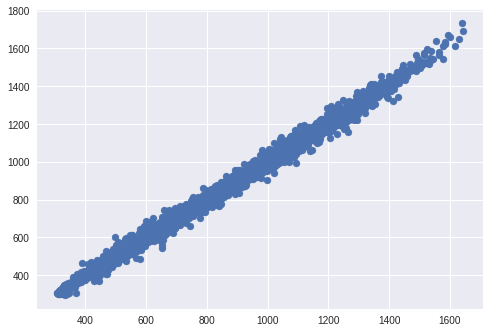

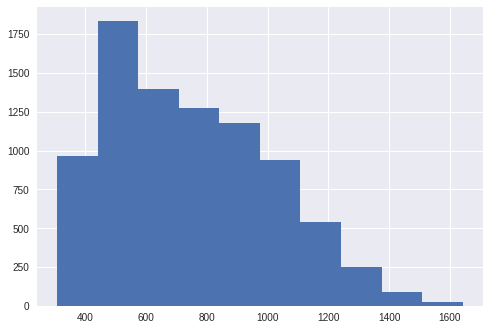

In [307]:
xgb_reg.fit(X_train_prep, y_train)

y_train_pred = rnd_reg.predict(X_train_prep)

print(f"Mean absolute error {mean_absolute_error(y_train_pred, y_train)}")
plt.scatter(y_train_pred, y_train)
plt.show()

plt.hist(y_train_pred)
plt.show()



---



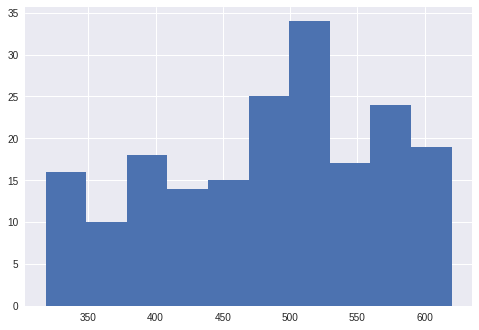

In [308]:

data_previ_total = np.c_[X_previ_prep, y_previ.values]

for i in range(len(data_previ_total)):
	
	if data_previ_total[i, -1] == 0:
		
		data = data_previ_total[i, :-1].reshape(1, -1)
		
		y_pred = xgb_reg.predict(data)
		
		n_prop = 73 if len(data_previ_total) - i > 73 else len(data_previ_total) - i
		
		j = data_previ_total.shape[1] - 1

		for k in range(n_prop):
			
			data_previ_total[k + i, j] = y_pred
			
			j = j - 1

plt.hist(data_previ_total[:, -1])
plt.show()

**Fin**